<a href="https://colab.research.google.com/github/vanislekahuna/Statistical-Rethinking-PyMC/blob/main/Chp_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistical Rethinking: A Bayesian course with examples in Python**
# **Chapter 5 - The Many Variables & The Spurious Waffles**

<img src="https://static.wikia.nocookie.net/harrypotter/images/5/54/Harry_Potter_being_sorted_PSF.jpg/revision/latest?cb=20150906012040" width=834 height=376>

[Source](https://harrypotter.fandom.com/wiki/Hogwarts_Houses)

## Main Points

Jump to [*Section 5.4*](#scrollTo=ldxTkcZeF61J)

In [ ]:
%%capture
!pip install networkx==3.4.2
!pip install numpy==1.26.4
!pip install pandas==2.2.2
!pip install plotly==5.24.1
!pip install pymc==5.19.1
!pip install arviz==0.20.0
!pip install seaborn==0.13.2
!pip install matplotlib==3.8.0
!pip install scipy==1.13.1
!pip install sklearn==1.6.0

In [ ]:
import os
import warnings

# import daft
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import pymc as pm
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt


# from aesara import shared
# from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import interp1d, griddata
from sklearn.linear_model import LinearRegression
from itertools import combinations

warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

In the U.S., there's a misleading correlation between the number of waffle houses in a given state and the likelihood of divorces in that states with a higher concentration of waffle houses also have the highest divorce rates. As far as we know there isn't a plausible mechanism explaining why waffle houses cause high divorce rates, but it does make us wonder whether there are other forces at play which explain the high divorce rates and have some connection to the frequency of waffle houses.

In large datasets, it's not surprising to find correlations or relationships between variables we wouldn't intuitively think have any connection to one another. However, since most correlations don't necessarily equate to causal relationships with one another, we need tools such as **multiple regression** models to distinguish between these associations.

As the name suggests, **multiple regression** is similar to linear regression in the sense that we're using a predictor variable to simulate an outcome we're interested in \(i.e. our target variable\), except that we're using various predictor variables to achieve this rather than just the one variable we're used to. Multiple Regression models are essential for the following reasons:

1. The multiple linear regression model helps us understand and predict a target variable by "controlling" for *confounding variables*, which are things which may mislead us into inferring a causal relationship between two or more variables. For example in the U.S., the states that have the highest concentration of waffle houses are in the southern United States so we may begin to associate Southern States with high likelihoods of divorce.

2. It's also important to account for the high likelihood that our target variable may be the product of a complex relationship between various predictor variables. For example, the effects of one predictor variable may cloud the effects of other predictor variables. With **multiple regression models**, we'll have the ability to *measure the effects of each of the predictor variables on the target variable separately and simultaneously* which therefore increases our understanding of the factors influencing the target variable.

3. In addition to understanding their separate effects, multiple regression models can help us understand the *interaction* between predictor variables. For example, having access to high-quality food and water each has a separate effect on the peak height of an individual wolf in comparison to other wolves. However, a wolf won't get very far if it doesn't have access to one or the other which is why it's important to understand how a certain predictor variable influences the target variable within the context of other predictors.

In [ ]:
# Load data
# data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

waffle_path = "https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/WaffleDivorce.csv"
data = pd.read_csv(waffle_path, delimiter=";")
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


### Figure 5.1. The number of waffle houses per million.

In [ ]:
data["WafHouse_per_million"] = data["WaffleHouses"] / data["Population"]
data.describe()

,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,WafHouse_per_million
count,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000
mean,6.119600,26.05400,20.114000,1.399400,9.688000,0.961800,32.340000,0.280000,79378.340000,6.287293e+05,0.094051,4.947834
std,6.876156,1.24363,3.797905,0.796975,1.820814,0.525367,65.789587,0.453557,149730.921149,7.813127e+05,0.174449,8.958811
min,0.560000,23.20000,13.500000,0.390000,6.100000,0.240000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,1.635000,25.32500,17.125000,0.810000,8.300000,0.572500,0.000000,0.000000,0.000000,4.332100e+04,0.000000,0.000000
50%,4.435000,25.90000,19.700000,1.185000,9.750000,0.795000,1.000000,0.000000,0.000000,4.077220e+05,0.000000,0.077942
75%,6.677500,26.75000,22.100000,1.767500,10.900000,1.257500,39.750000,1.000000,80828.000000,9.209770e+05,0.085000,4.816667
max,37.250000,29.70000,30.700000,3.920000,13.500000,2.500000,381.000000,1.000000,490865.000000,3.880735e+06,0.570000,39.318885


In [ ]:
slope, y_int, r2, p_val, std_error = stats.linregress(data["WafHouse_per_million"], data["Divorce"])
WafHouse_per_mil_mean = data["WafHouse_per_million"].mean()
WafHouse_per_mil_std = data["WafHouse_per_million"].std()

In [ ]:
with pm.Model() as m_waffles:
    a = pm.Normal("a", mu=y_int, sigma=std_error)
    b_A = pm.Normal("b_A", mu=WafHouse_per_mil_mean, sigma=data["WafHouse_per_million"].std())
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b_A * data["WafHouse_per_million"])
    divorce_rate = pm.Normal("divorce_rate", mu=mu, sigma=sigma, observed=data["Divorce"])
    trace_waffles = pm.sample()

waffle_mu_pred = trace_waffles.posterior["mu"]
with m_waffles:
    divorce_pred = pm.sample_posterior_predictive(trace_waffles)

Output()

Output()

Output()

Text(1.32, 0.75, "Figure 5.1. The number of Waffle House \n     diners per million is associated with \n     divorce rates (in the year 2009) within the \n     United States. Each point is a State. \n     'Southern' (former Confederate) States shown in \n     blue. Shaded region is 89% percentile interval \n     of the mean. These data are in \n     $data(waffleDivorce)$ in the $rethinking$ \n     package")

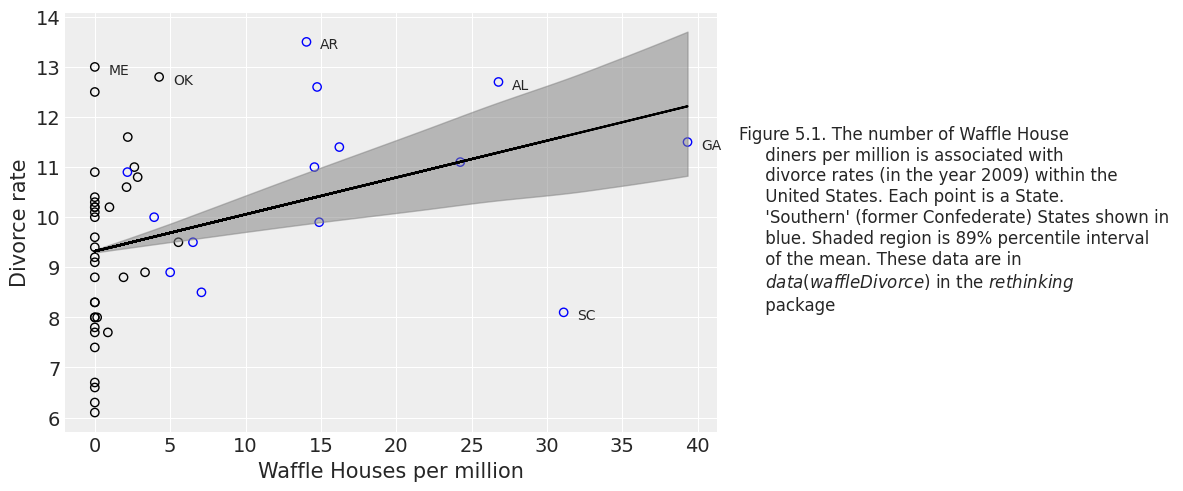

In [ ]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))

#####################
### CODE ADDITION ###
#####################

# Generating the linear regression plot line:
ax.plot(data["WafHouse_per_million"], waffle_mu_pred.mean(axis=1)[1], color="black")
az.plot_hdi(data["WafHouse_per_million"], waffle_mu_pred, hdi_prob=0.89, ax=ax, color="grey") # The HDI of the linear model of the prior.

# Adding the graph explanations from the textbook
plt.suptitle(
    x=1.32,
    y=.75,
    t="Figure 5.1. The number of Waffle House \n \
    diners per million is associated with \n \
    divorce rates (in the year 2009) within the \n \
    United States. Each point is a State. \n \
    'Southern' (former Confederate) States shown in \n \
    blue. Shaded region is 89% percentile interval \n \
    of the mean. These data are in \n \
    $data(waffleDivorce)$ in the $rethinking$ \n \
    package",
    ma="left"
  )

#####################
#####################

In this chapter, we'll use multiple regression models to help us understand the effects of various predictor variables and account for the confounding factors in our analysis \(points 1 and 2 \). From the Bayesian sense, this will involve using various combinations of our predictor variables to reveal *spurious* combinations between two variables in our dataset as well as identify correlations that may have been *masked* by other predictor variables.

One thing to note about multiple regression models is that they can be very damaging if we add variables to our models thoughtlessly. To overcome some of these issues, we'll also introduce **causal inference** and **graphical causal models** as a method to design and interpret regression models.

<img src="https://images.wsj.net/im-122970/?width=700&size=1.5" width=700 height=500>


Source: [Steven Allen](https://www.wsj.com/articles/if-you-can-manage-a-waffle-house-you-can-manage-anything-11572667205)

#### **Rethinking: Causal inference.**

Despite its central importance, there is no unified approach to causal inference in the sciences. Some people argue that causation is a psychological illusion. In complex dynamical systems, everything seems to cause everything which therefore causes "cause" to lose its value. While there are many disagreements across the board on causal inference, there's one thing many people agree on: That is, *causal inference always depends on unverifiable assumptions.* In other words, it's always possible to spot scenarios where your inference about the cause is mistaken, no matter how careful you are about the design or analysis. However, a lot can still be accomplished despite this drawback.

### Figure 5.2. The relationship between divorce rates and the marriage rates \(left\) and the median age of marriage \(right\) for each state.

<ipython-input-9-8a10497c1c39>:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


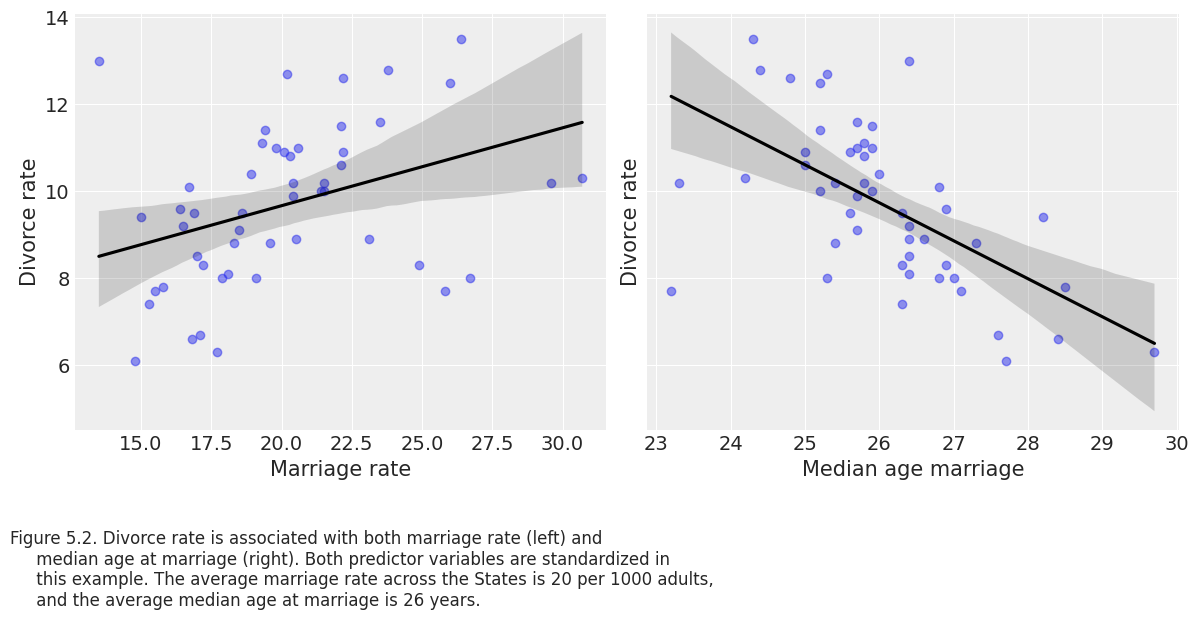

In [ ]:
# Fig 5.2, missing mean and CI
# fid, ax = plt.subplots(1, 2, figsize=(10, 4))

# ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
# ax[0].set_ylabel("Divorce rate")
# ax[0].set_xlabel("Marriage rate")

# ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
# ax[1].set_ylabel("Divorce rate")
# ax[1].set_xlabel("Median age marriage")

#####################
### CODE ADDITION ###
#####################
# Create a custom axis object
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

# Plot the first Linear Regression
sns.regplot(x="Marriage", y="Divorce", data=data, ax=axes[0], scatter_kws={"alpha": 0.5}, line_kws={"color": "black"})
axes[0].set_xlabel("Marriage rate")
axes[0].set_ylabel("Divorce rate")

# Plot the second Linear Regression
sns.regplot(x="MedianAgeMarriage", y="Divorce", data=data, ax=axes[1], scatter_kws={"alpha": 0.5}, line_kws={"color": "black"})
axes[1].set_xlabel("Median age marriage")
axes[1].set_ylabel("Divorce rate")

# Set common y-axis label
# fig.text(0.08, 0.5, "Divorce", va="center", rotation="vertical")

# Adjust the layout
plt.tight_layout()

plt.suptitle(
    x=0.3,
    y=-0.07,
    t="Figure 5.2. Divorce rate is associated with both marriage rate (left) and \n \
    median age at marriage (right). Both predictor variables are standardized in \n \
    this example. The average marriage rate across the States is 20 per 1000 adults, \n \
    and the average median age at marriage is 26 years.",
    ma="left"
  )

plt.show()

## *Section 5.1* - Spurious Association

One example we can use to cement our understanding of faulty correlations is the relationships between the divorce rate and marriage rate, as depicted in the left-hand plot of **Figure 5.2**. As we can see from the graph, there seems to be a positive relationship between marriage rate and divorce where the higher the marriage rate per 1000 adults for a given rate, the higher the divorce rate seems to be as well. However, the question we have to ask ourselves is whether the marriage rate *causes* divorce? Well in some sense it does because one cannot get a divorce if they weren't married in the first place. However, if, for example, a population places a high cultural value on marriage to begin with, an assumption we could make is that adults want to live long and happy lives in their marriage which should therefore result in *lower* divorce rates. So why is there a positive correlation between the two?

Another predictor that's related to divorce is the median age of marriage per state which seems to have a negative relationship with divorce which has been visualized in the right-hand plot of **Figure 5.2**. In other words, the older people seem to be when they tie the knot, the lower the chances are that the marriage will end in divorce. However, there's no reason to suspect that the median age of marriage is a causal predictor of divorce.


To start our investigation, we should start by standardizing the variable of interest:

In [ ]:
# Code for Standard Scaler which scales the data so that they centre around 0 which represents the features' mean and has a standard dev of 1.

def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

#### Code 5.1

In [ ]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

The Linear Regression model used for the last two graphs is below:

$ D_i \sim \text{Normal}(\mu_i, \sigma) $ \[the likelihood \]

$ \mu_i = \alpha + \beta_A A_i $ \[the linear model \]

$ \alpha \sim \text{Normal}(0, 0.2) $ \[the $\alpha$ prior or the y-intercept \]

$ \beta_A \sim \text{Normal}(0, 0.5) $ \[the $\beta$ prior or the slope of $m$ \]

$ \sigma \sim \text{Exponential}(1) $ \[the $\sigma$ prior or the standard deviation \]

$Where$:

- $D_i$is the standardized `Divorce_std` rate \(zero-centered, a standard deviation of one \) divorce rate for State $i$;

- $A_i$ is State $i$'s standardized `MedianAgeMarriage_std`;

- $\alpha$ is the y-intercept which should have a mean \(centre\) of 0.

- $\beta_A$ is the prior slope where if the $\beta_A = 1$, that would imply that a one standard deviation departure from the average divorce rate in the United States will lead to a change of 1.2 years in a state's median age of marriage.

#### Code 5.2

Below, we'll see what the value is for one standard deviation of the median age of marriage across all states:

In [ ]:
print(data["MedianAgeMarriage"].mean())
data["MedianAgeMarriage"].std()

26.053999999999995


1.243630301388082

Again, to re-summarize, what this means is that when $\beta_A$ = 1, one standard deviation away from the average U.S divorce rate equates to a 1.24-year departure from the average median age of marriage. So if the un-standardized average for the median age of marriage is $26.05$ years old, then one standard deviation from the average equates to either

A) An increase of $1.24$ years to that value \($26.05 + 1.24 = 27.29$\) or;

B) A decrease of $1.24$ years old \($26.05 - 1.24 = 24.81$\).

### Statistical Review: Standard Deviations

As a reminder about the fundamental properties of standard deviations:

1. About 68% of the data falls within ±1 standard deviation of the mean \(i.e. $\pm1$ SD = $\pm0.5$ (68\% of data)\)

2. About 95% of the data falls within ±2 standard deviation of the mean \( i.e. $\pm2$ SD = $\pm1.0$ (95\% of data) \)

3. $\pm3$ SD = $\pm1.5$ (99.7\% of data)

To prove that, for example, 68% of the bell curve within a normal distribution, $ \text{Normal}(0, 0.5) $, we need to use the properties of a normal probability density function, probability theory, and integration.

1. The equation for a probability density function (pdf) is the following:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ pdf(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $


2. To find the probability within ±1 standard deviation:
 - We need to integrate this function from -0.5 to 0.5
 - This gives us the area under the curve between these points
 - This area represents the probability

3. This leads us to the formula for the probability of a value being one standard deviation away from the mean, which in our example is 0:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ P(-0.5 \leq X \leq 0.5) = \int_{-0.5}^{0.5} \frac{1}{0.5\sqrt{2\pi}} e^{-\frac{x^2}{2(0.5)^2}} $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; OR

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ P(-\sigma \leq X \leq \sigma) = \int_{-\sigma}^{\sigma} \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{x^2}{2\sigma^2}} $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ dx \approx 0.68 $

Note: When there's a $ \int_{} $ sign, it symbolizes an integration. So in this case, the variable $dx$ indicates that a function is being integrated concerning $x$.

In [ ]:
import math

# Here's the accompanying Python code to calculate pdf
def normal_pdf(x, mu=0, sigma=0.5):
    """
    Calculate normal distribution PDF for given x, mean (mu), and std dev (sigma)
    """

    pdf = (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-(x - mu)**2 / (2 * sigma**2))

    return pdf


# To approximate the integral (probability), we can use the following code for a simple numerical integration
def probability_within_n_sd(mu=0, sigma=0.5, steps=1000, n=1):
    """
    Calculate probability within 1 standard deviation using numerical integration
    """
    # Define bounds: mu ± sigma
    lower_bound = mu - n*sigma
    upper_bound = mu + n*sigma

    # Width of each rectangle for numerical integration
    dx = (upper_bound - lower_bound) / steps

    # Sum up areas of rectangles
    total = 0
    for i in range(steps):
        x = lower_bound + i * dx
        total += normal_pdf(x, mu, sigma) * dx

    return total

# Calculate and print result
x_standard_deviation = 2
prob = probability_within_n_sd(n=x_standard_deviation)
print(f"Probability within {x_standard_deviation} standard deviation(s): {prob:.4f}")

Probability within 2 standard deviation(s): 0.9545


#### Code 5.3 - Model `m5_1` for `MedianAgeMarriage_std`/`Divorce_std`

However, this is a problem because our model seems to think that only 5% of plausible slopes are greater than 1? Let's see if we can learn more by approximating a posterior distribution:

In [ ]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2) # Tighter distribution
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )

    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Output()

Output()

In [ ]:
az.summary(m_5_1_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.097,-0.187,0.173,0.002,0.002,2937.0,1608.0,1.0
bA,-0.564,0.117,-0.776,-0.353,0.002,0.002,2706.0,1416.0,1.0
mu[0],0.341,0.120,0.123,0.564,0.002,0.002,2684.0,1404.0,1.0
mu[1],0.387,0.126,0.156,0.621,0.002,0.002,2662.0,1367.0,1.0
mu[2],0.114,0.100,-0.077,0.299,0.002,0.002,2881.0,1574.0,1.0
mu[3],0.795,0.191,0.448,1.154,0.004,0.003,2571.0,1267.0,1.0
mu[4],-0.339,0.120,-0.557,-0.116,0.002,0.002,2942.0,1656.0,1.0
mu[5],0.160,0.103,-0.021,0.366,0.002,0.001,2849.0,1559.0,1.0
mu[6],-0.702,0.175,-1.040,-0.389,0.003,0.002,2878.0,1713.0,1.0
mu[7],-0.249,0.110,-0.437,-0.033,0.002,0.002,2952.0,1689.0,1.0


Text(0.5, 1.0, 'sigma')

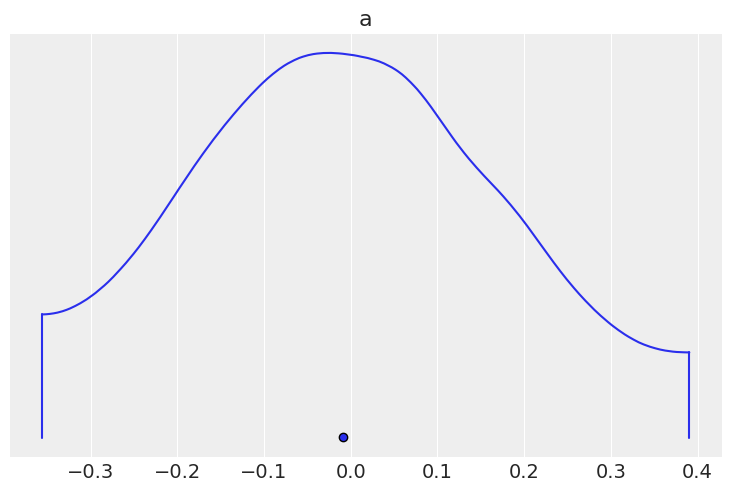

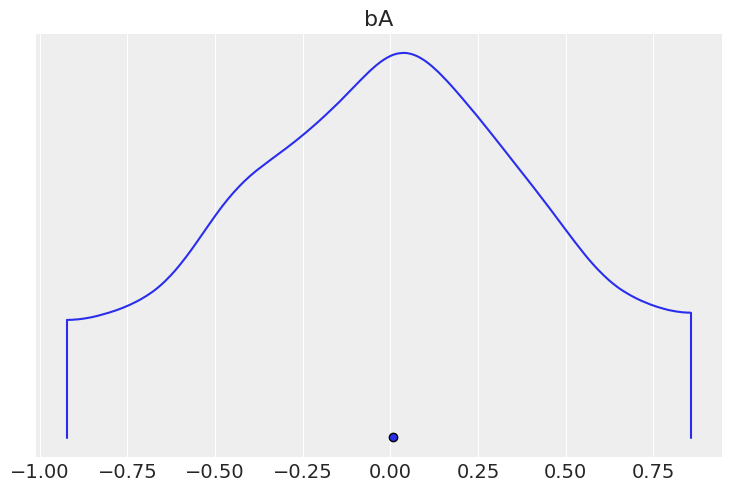

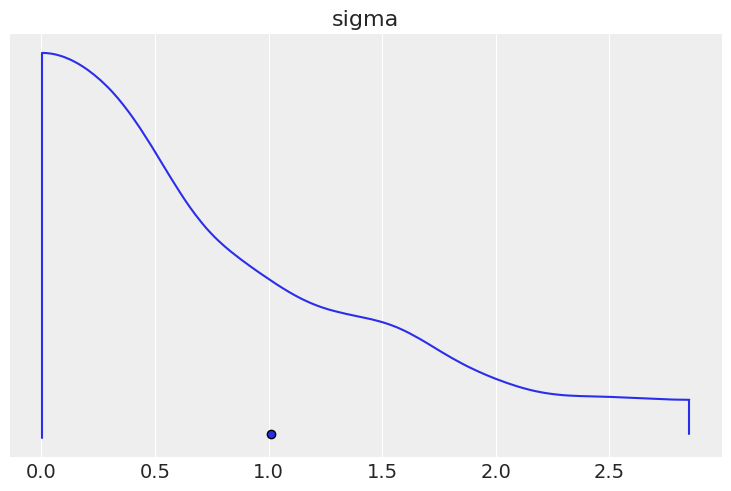

In [ ]:
height_rng = np.random.default_rng(2971)

N_sim = 1000
a_sim = stats.norm.rvs(0, 0.2, N_sim)
bA_sim = stats.norm.rvs(0, 0.5, N_sim)
sigma_sim = stats.expon.rvs(size=N_sim)

az.plot_density(a_sim)
plt.title("a")

az.plot_density(bA_sim)
plt.title("bA")

az.plot_density(sigma_sim)
plt.title("sigma")

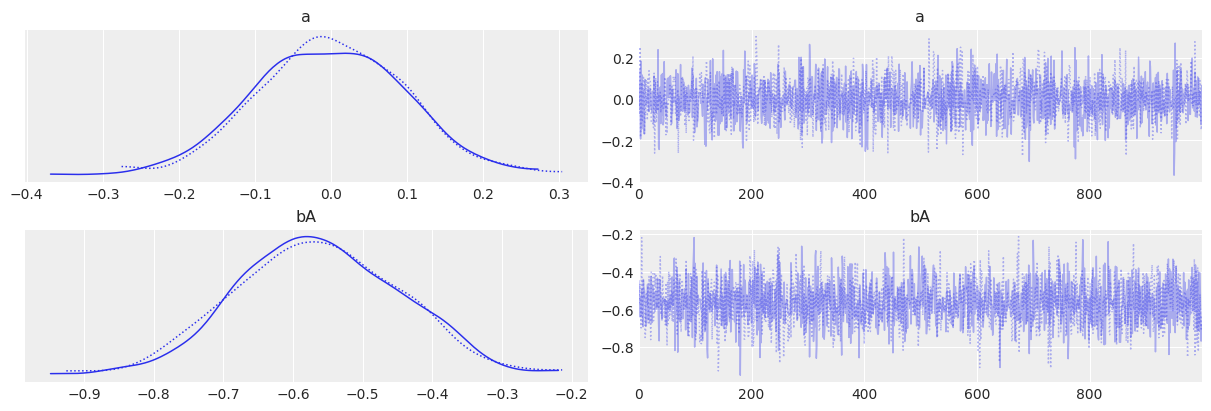

In [ ]:
az.plot_trace(m_5_1_trace, var_names=["a", "bA"]);

#### Code 5.4

Once we've simulated the priors, we'll plot the regression lines over the range of 2 standard deviations for both the predictor and target variable to cover almost all the range of possible values:

#### Figure 5.3. Plausible regression lines implied by the priors.

Text(1.32, 0.75, 'Figure 5.3. The plausible regression lines implied \n     by the priors in $m5.1$. These are weakly \n     informative priors in that they allow some \n     implausibly strong relationships but generally \n     bound the lines to possible ranges of the variables.')

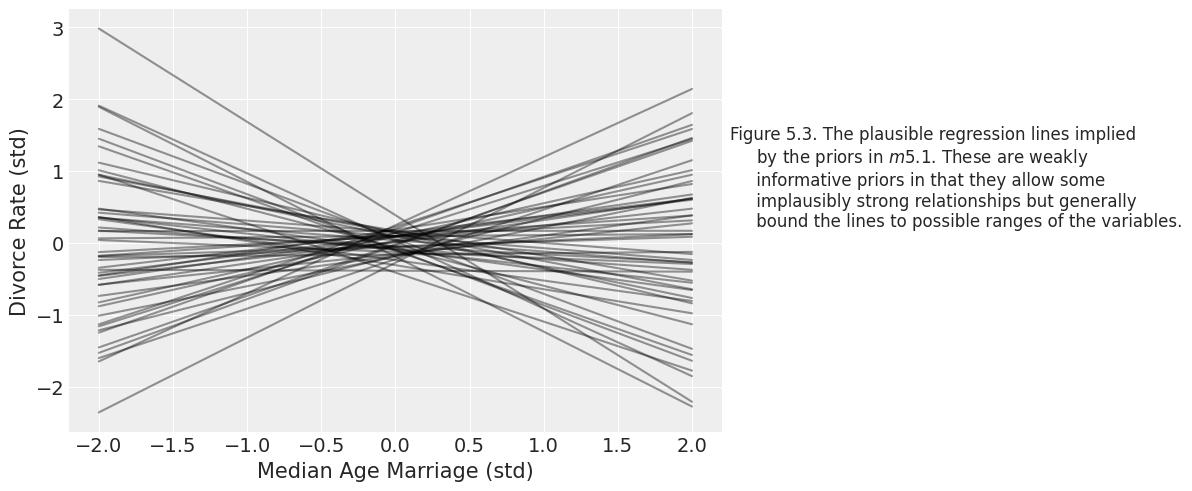

In [ ]:
fig, ax = plt.subplots()

# Generating two standard deviations away from the mean of 0
x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
# fig.suptitle("Figure 5.3")

#####################
### CODE ADDITION ###
#####################

# Adding the graph explanations from the textbook
plt.suptitle(
    x=1.32,
    y=.75,
    t="Figure 5.3. The plausible regression lines implied \n \
    by the priors in $m5.1$. These are weakly \n \
    informative priors in that they allow some \n \
    implausibly strong relationships but generally \n \
    bound the lines to possible ranges of the variables.",
    ma="left"
  )

#### Code 5.5

We can see the result of all the possible regression lines for the predictor and the target variables within the range of two standard deviations of the mean (i.e. where 95% of the data fits within the curve). If we remove the standardization from the median age, we'll find that 95% of their distribution is within years.

In [ ]:
n_std = 2
std_dev = data["MedianAgeMarriage"].std() * n_std
mean_median_age = data["MedianAgeMarriage"].mean()

print(f"The median age of marriage is {mean_median_age:.2f} where {n_std} standard deviations from the mean equate to {std_dev:.2f} years. \
This would give us a range of {(mean_median_age - std_dev):.2f} and {(mean_median_age + std_dev):.2f} median years of age.")

The median age of marriage is 26.05 where 2 standard deviations from the mean equate to 2.49 years. This would give us a range of 23.57 and 28.54 median years of age.


Now let's generate posterior predictions and plot the results:

In [ ]:
m_5_1_trace.posterior["bA"].shape

(2, 1000)

This is equivalent of Prof McElreath's `link` function

In [ ]:
age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# m_5_1_trace = m_5_1_trace.sel(draw=slice(None, None, 10))
m_5_1_data = az.extract_dataset(m_5_1_trace.posterior)

mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data["a"] + m_5_1_data["bA"] * age_std

Text(0, 0.5, 'Divorce rate')

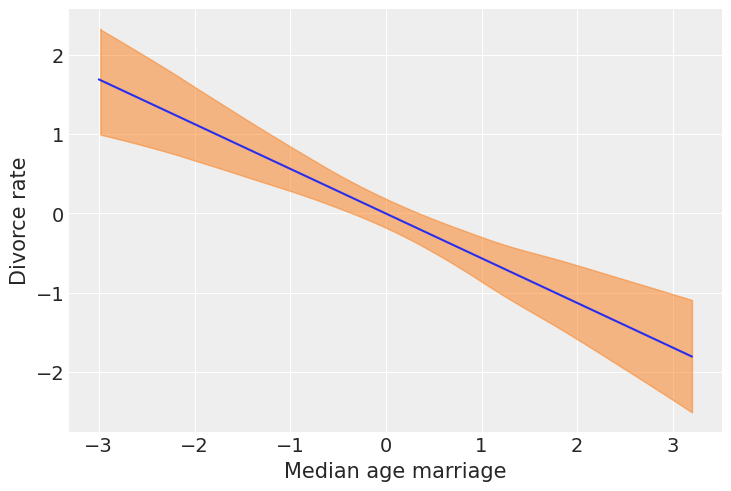

In [ ]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate")

Similar to the right-hand plot in **Figure 5.2**, we'll find a negative posterior for $\beta_A$ where divorce rates tend to decrease as the median age increases.

#### Code 5.6 - Model `m5_2` for `Marriage_std`/`Divorce_std`

Now let's fit a similar Linear Model for the left-hand plot in **Figure 5.2** which examines the relationship between divorce rates and marriage rates:

$ D_i \sim \text{Normal}(\mu_i, \sigma) $ \[the likelihood \]

$ \mu_i = \alpha + \beta_R R_i $ \[the linear model \]

$ \alpha \sim \text{Normal}(0, 0.2) $ \[the $\alpha$ prior \]

$ \beta_R \sim \text{Normal}(0, 0.5) $ \[the $\beta$ prior \]

$ \sigma \sim \text{Exponential}(1) $ \[the $\sigma$ prior \]

$Where$:

- $D_i$is the standardized `Divorce_std` rate \(zero-centered, a standard deviation of one \) divorce rate for State $i$;

- $R_i$ is State $i$'s standardized `Marriage_std`;

- $\alpha$ is the y-intercept which should have a mean \(centre\) of 0.

- $\beta_R$ is the prior slope where if the $\beta_R = 1$, that would imply that a one standard deviation departure from the average divorce rate in the United States will lead to a change of 3.79 in a state's marriage rate. So in other words, when the slope of $\beta_R$ = 1, one standard deviation away from the average U.S divorce rate equates to a departure of 3.79 from the average marriage rate across the U.S. Therefore, if the un-standardized average marriage rate is $20.11$, then one standard deviation from the average equates to an increase of $3.79$ to that value \($20.11 + 3.79 = 24.01$\).

In [ ]:
print(data["Marriage"].mean())
data["Marriage"].std()

20.114000000000004


3.797905437775632

In [ ]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Output()

Output()

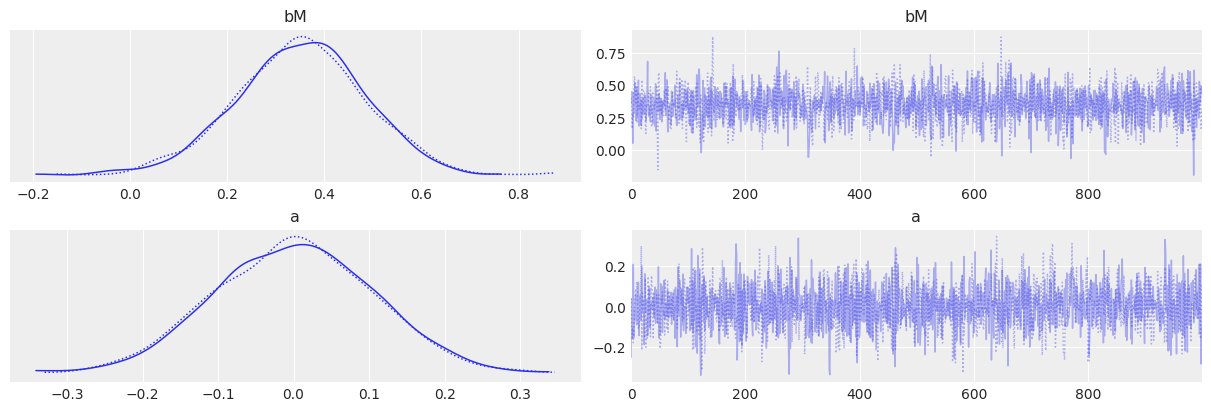

In [ ]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

Text(0, 0.5, 'Divorce rate')

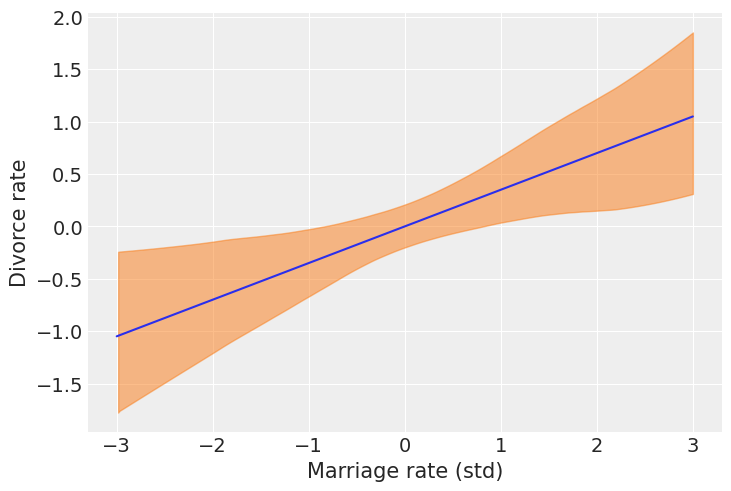

In [ ]:
marr_std_seq = np.linspace(-3, 3, 100)
m_5_2_data = az.extract_dataset(m_5_2_trace.posterior)

mu_pred_marr = np.zeros((len(marr_std_seq), len(m_5_2_data.sample)))

for i, marr_std in enumerate(marr_std_seq):
    mu_pred_marr[i] = m_5_2_data["a"] + m_5_2_data["bM"] * marr_std

mu_mean_marr = mu_pred_marr.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(marr_std_seq, mu_pred_marr.T)
plt.plot(marr_std_seq, mu_mean_marr)
ax.set_xlabel("Marriage rate (std)")
ax.set_ylabel("Divorce rate")

In [ ]:
az.summary(m_5_2_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.108,-0.188,0.215,0.002,0.002,2840.0,1623.0,1.0
bM,0.350,0.132,0.124,0.616,0.003,0.002,2319.0,1409.0,1.0
mu[0],0.009,0.108,-0.185,0.219,0.002,0.002,2831.0,1602.0,1.0
mu[1],0.543,0.231,0.126,0.990,0.005,0.003,2390.0,1416.0,1.0
mu[2],0.018,0.109,-0.176,0.230,0.002,0.002,2812.0,1605.0,1.0
mu[3],0.579,0.243,0.134,1.046,0.005,0.004,2373.0,1459.0,1.0
mu[4],-0.093,0.114,-0.302,0.120,0.002,0.002,2907.0,1744.0,1.0
mu[5],0.313,0.159,0.014,0.609,0.003,0.002,2484.0,1416.0,1.0
mu[6],-0.277,0.152,-0.552,0.015,0.003,0.002,2687.0,1723.0,1.0
mu[7],0.276,0.150,-0.008,0.547,0.003,0.002,2498.0,1482.0,1.0


So if we were to merely compare the parameter values such as slope in either of our linear models in `m_5_1` or `m_5_2`, there's no way to decide which is a better predictor of divorce rates between median age of marriage for a given state or its marriage rate. These predictors can either provide independent value, be redundant, or could eliminate the value of one another.

To make sense of the factors which influence divorce rates, we're going to have to think <u>causally</u> about this which will then allow us to build a bigger regression model that includes both the median age and marriage rate as predictors of divorce.

### 5.1.1. Think before you regress.

In Code 5.8, what we've just built there is a particular type of **causal graph** known as a **Directed Acyclic Graph (DAG)** which is a way of describing qualitative causal relationships amongst variables and contains information that a purely statistical model does not. Below is a brief description of each letter in the DAG acronym:

1. **Directed** means the connections have arrows that indicate the <u>direction</u> of the causal influence;
2. **Acyclic** means they are <u>one-directional</u> and <u>do not eventually flow back on themselves</u>.
3. And the **graph** represents the <u>nodes</u> AND <u>connections</u>;

Below is another example of a <u>directed acyclic graph \(DAG\) </u> where the direction does not eventually flow back onto itself:

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c6/Topological_Ordering.svg" width=700 height=500>

Source: [Wikipedia](https://en.wikipedia.org/wiki/Directed_acyclic_graph)

<br>

Unlike a statistical model, the DAG will tell you the consequences of intervening to change a variable, \*assuming\* that the DAG is correct in the first place. Throughout this chapter, we're going to build the intuition of designing DAG's and critiquing statistical models. On the other hand, Code 5.7 is an example of a <u>***cyclic*** graph</u> because it contains at least one cycle where the path begins and ends at the same node.


#### Code 5.7
Credit to [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/05_the_many_variables_and_the_spurious_waffles#Code-5.7)


The author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate each other.

How do we understand all this?

He explains that here we may want to think **causally**.

A few interesting assumptions (or rather deductions) -

* a) Age (A) has a direct impact on the Divorce rate (D) as people grow incompatible with their partners (represented by Figure 5.2 (right)). Another way to think about this is that people who get married at an older age are more mature and tend to have a better understanding of themselves and what they need in a partner which is why there are typically lower divorce rates associated with people who get married at an older age;

* b) Marriage Rate (M) has a direct impact on Divorce rate (D) for obvious reasons (more marriages = more chances of divorce)

* c) Finally, Age (A) has an impact on Marriage Rate (M) because there are more young people

Another way to represent the above is :

A -> D

M -> D

A -> M

And yet another way is to use **DAG** (Directed Acyclic Graphs).

If we go down the path where $A → M → D$, what we're saying is that *age* <u>indirectly</u> influences the divorce rate because there generally are more people in the population who are around the age of 25 as opposed to the age of 65 since fewer people live to that age. Since there are more people available to be married at a younger age, we can expect a higher marriage rate as opposed to when we see an older population which may equate to lower marriage rates \( $\uparrow A$ge / $\downarrow M$arriage rate).

So as we saw on the left-hand graph of Figure 5.2 where a higher marriage rate seems to lead to a higher divorce rate, then we can argue that age must have *some* effect on the divorce rate.

At this point, we're left at a crossroads where we have to figure out:

1. Option A: Does median age, $A$, explicitly affect the divorce rate, $D$, resulting in a **direct effect** ( $A → D$ )?

OR

2. Option B: Does median age, $A$, have an **indirect effect** on divorce rate, $D$, through the marriage rate, $M$? Basically, if we assume that age and marriage rate are negatively correlated \( $\uparrow A$ge / $\downarrow M$arriage rate) because a higher median age means there are fewer people available to get married ( $A \rightarrow M$ ), then arguably age does have *some effect* on the divorce rate, $D$, by way of the correlation that we've established between marriage rate, $M$, and divorce, $D$. This is just a long-winded way of establishing the indirect effect that age might have on divorce through the marriage rate ( $A → M → D$ ).

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


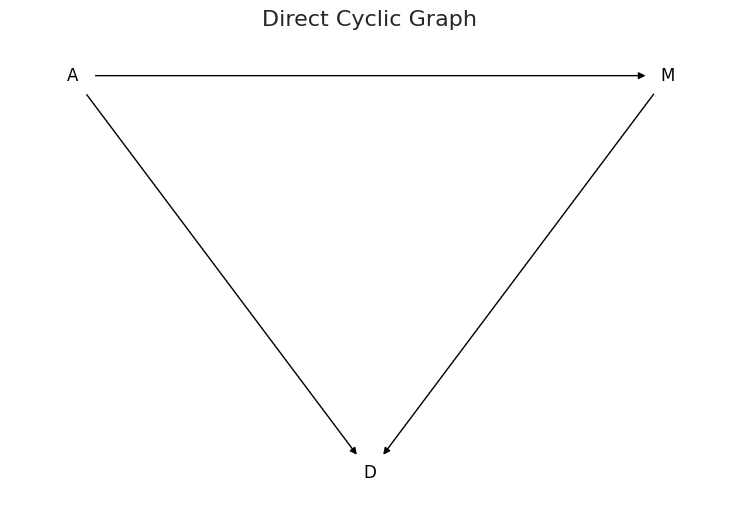

In [ ]:
#####################
### Original Code ###
#####################

# from causalgraphicalmodels import CausalGraphicalModel

# dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
# pgm = daft.PGM()
# coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
# for node in dag5_1.dag.nodes:
#     pgm.add_node(node, node, *coordinates[node])
# for edge in dag5_1.dag.edges:
#     pgm.add_edge(*edge)
# pgm.render()
# plt.gca().invert_yaxis()



###########
# MY CODE #
###########

# Create a directed graph
DAG = nx.DiGraph()

# Add nodes
DAG.add_node("A", pos=(0, 0))
DAG.add_node("M", pos=(1, 0))
DAG.add_node("D", pos=(0.5, -1))

# Add edges (vertices)
DAG.add_edge("A", "M")
DAG.add_edge("M", "D")
DAG.add_edge("A", "D")

# Get node positions
node_positions0 = nx.get_node_attributes(DAG, 'pos')

# Draw the graph
nx.draw(DAG, node_positions0, with_labels=True, node_size=1000, font_size=12, font_color='black', node_color='white')

# Display the graph
plt.title("Direct Cyclic Graph")
plt.show()

#### Code 5.8

The above direct cyclical graph clearly shows that $A$ impacts $D$, either directly or indirectly (i.e. via $M$)

The author used "total influence". What is meant by *total* is that we need to account for every path from **A** to **D**. So either $A$ influences $D$ *directly* \($A → D$\) or *indirectly* \($A → M \rightarrow D$\).

**MEDIATION** - In general, it is possible to say that **A** did not directly influence **D**; rather it did it via **M**. This type of relationship is called **Mediation** which is an indirect influence.

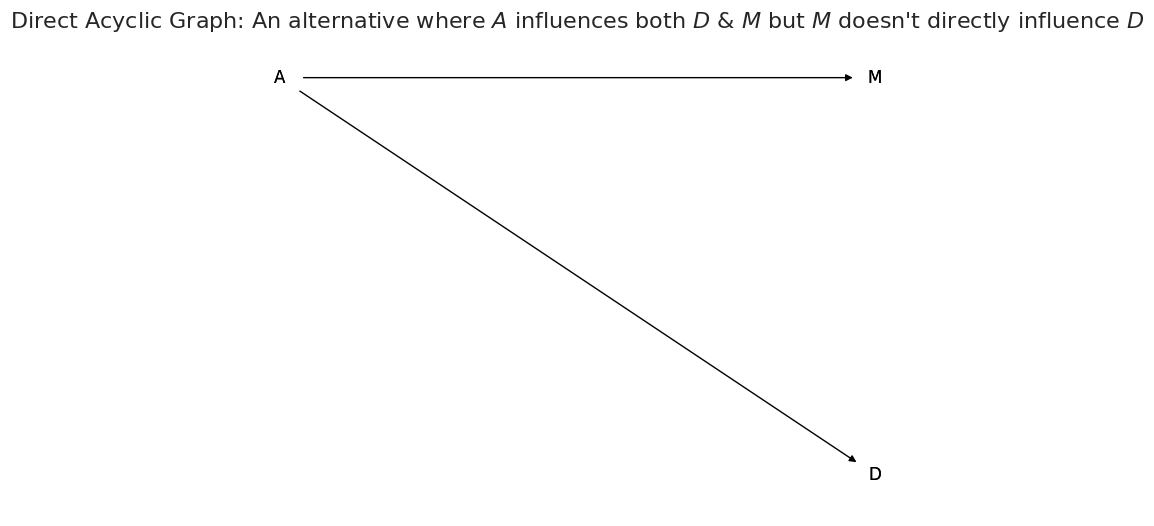

In [ ]:
#####################
### Original Code ###
#####################

# # Note - There is no explicit code section for drawing the second DAG
# # but the figure appears in the book and hence drawing it as well
# dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
# pgm = daft.PGM()
# coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
# for node in dag5_2.dag.nodes:
#     pgm.add_node(node, node, *coordinates[node])
# for edge in dag5_2.dag.edges:
#     pgm.add_edge(*edge)
# pgm.render()
# plt.gca().invert_yaxis()



################################################
# MY CODE REPLACEMENT FOR THE ABOVE CODE BLOCK #
################################################

# Create a directed graph
DAG = nx.DiGraph()

# Add nodes
DAG.add_node("A", pos=(0, 0))
DAG.add_node("M", pos=(1, 0))
DAG.add_node("D", pos=(1, -1))

# Add edges (vertices)
DAG.add_edge("A", "M")
DAG.add_edge("A", "D")

# Get node positions
node_positions = nx.get_node_attributes(DAG, 'pos')

# Draw the graph
nx.draw(DAG, node_positions, with_labels=True, node_size=1000, font_size=12, font_color='black', node_color='white')

# Add labels to nodes
labels = {"A": "A", "M": "M", "D": "D"}
nx.draw_networkx_labels(DAG, node_positions, labels=labels, font_size=12)

# Display the graph
plt.title("Direct Acyclic Graph: An alternative where $A$ influences both $D$ & $M$ but $M$ doesn't directly influence $D$")
plt.show()

The DAG above is *also* consistent with models `m_5_1` and `m_5_2` because both $M$ and $D$ "listen" to $A$. So when you decide to inspect the association between $M$ and $D$, you pick up that common information that they both got from listening to $A$.

So now the question we have to ask ourselves here is if there is indeed a direct effect of marriage rate on divorce rate \(i.e. Does $M → D ?$\) OR rather is age within marriage just driving both, thus creating a **spurious** correlation between marriage rate and divorce rate? It's reasonable to assume that in the positive relationship between marriage rate and divorce, there is information about age which is also influencing the marriage rate and thus questions our assumption on the true effect marriage rate has on divorce.

### Rethinking: What's a cause?

Knowing a cause in statistics means being able to correctly predict the consequences of an intervention but sometimes, there are scenarios where even this is complicated. For example, if we wanted to lower someone's body weight, one way we can do so is by intervening on factors like their diet. However, it doesn't diet isn't always capable of *causing* weight as there may be other factors, such as genetics or disease, that can influence weight despite our best efforts to monitor what we eat or how much we eat.

### 5.1.2. Testable Implications

We can consider something called **testable implications** to compare multiple, plausible causal models. Consider the two DAGs we've written so far:

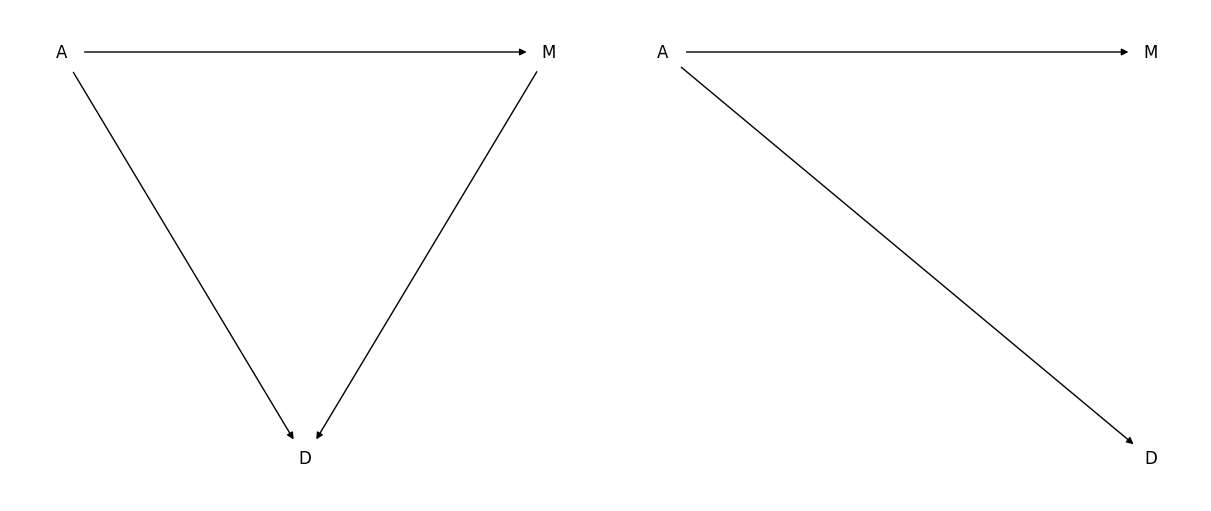

In [ ]:
###########
# MY CODE #
###########
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

# Creating a directed CYCLIC graph
DAG1 = nx.DiGraph()

# Add nodes
DAG1.add_node("A", pos=(0, 0))
DAG1.add_node("M", pos=(1, 0))
DAG1.add_node("D", pos=(0.5, -1))

# Add edges (vertices)
DAG1.add_edge("A", "M")
DAG1.add_edge("M", "D")
DAG1.add_edge("A", "D")

# Get node positions
node_positions1 = nx.get_node_attributes(DAG1, 'pos')

# Draw the graph
nx.draw(DAG1, ax=ax[0], pos=node_positions1, with_labels=True, node_size=1000, font_size=12, font_color='black', node_color='white')


# Creating a directed ACYCLIC graph
DAG2 = nx.DiGraph()

# Add nodes
DAG2.add_node("A", pos=(0, 0))
DAG2.add_node("M", pos=(1, 0))
DAG2.add_node("D", pos=(1, -1))

# Add edges (vertices)
DAG2.add_edge("A", "M")
DAG2.add_edge("A", "D")

# Get node positions
node_positions2 = nx.get_node_attributes(DAG2, 'pos')

# Draw the graph
nx.draw(DAG2, ax=ax[1], pos=node_positions2, with_labels=True, node_size=1000, font_size=12, font_color='black', node_color='white')

Any DAG may imply that some variables are independent of others under certain conditions, a term we call **conditional independencies**, and often come in 2 forms:

1. First, they are statements of which variables should be associated with one another \(or not\) in the data.
2. Second, they are statements of which variables become dis-associated when we *condition* on some other set of variables.

But what does "**conditioning**" mean? In the context of our **Directed Acyclic Graph \(DAG\)** on the right, it means learning about a variable like median age \($A$\), then asking if marriage rate \($M$\) adds any additional information on what we know about divorce rates \($D$\). If learning more about $M$ DOESN'T give us more information about $D$ \( i.e. IF $ A → D $ ONLY), then we can say that *$D$ is independent of \( $\perp\kern-5pt\perp$ \) $M$, conditional on $A$*:

$D \perp\kern-5pt\perp M \mid A$

By that logic, we can also say that $M$ is independent of \($\perp\kern-5pt\perp$\) $D$, conditional on $A$:

$M \perp\kern-5pt\perp D \mid A$

On the other hand, with our **Directed <u>*Cycle*</u> Graph** on the left, we'll find that every pair of variables is correlated, as indicated by each of the causal arrows. Therefore, we can imply that each node is associated with one another which we can therefore infer as a **testable implication**. We can write, or communicate our testable implication below \(note that $\not\!\perp\!\!\!\perp$ means "*not independent of*"\):

$ D \not\!\perp\!\!\!\perp A $

$ D \not\!\perp\!\!\!\perp M $

$ A \not\!\perp\!\!\!\perp M $

We can also get the joint probability distribution implied by our causal graphical model in `DAG2` using...

In [ ]:
def get_paths(G, start, end):
    """Get all paths between two nodes in graph"""
    return list(nx.all_simple_paths(G.to_undirected(), start, end))

def is_collider(G, node, path):
    """Check if a node is a collider in a path"""
    if path.index(node) == 0 or path.index(node) == len(path) - 1:
        return False
    prev_node = path[path.index(node) - 1]
    next_node = path[path.index(node) + 1]
    # Check if arrows point into the node from both sides
    return G.has_edge(prev_node, node) and G.has_edge(next_node, node)

def is_path_blocked(G, path, conditioning_set):
    """
    Check if a path is blocked given a conditioning set
    Returns True if path is blocked, False if open
    """
    for i, node in enumerate(path):
        if i == 0 or i == len(path) - 1:
            continue

        # Check if node is a collider
        if is_collider(G, node, path):
            # If collider or its descendants not in conditioning set, path is blocked
            if node not in conditioning_set and not any(desc in conditioning_set
                for desc in nx.descendants(G, node)):
                return True
        else:
            # If non-collider is in conditioning set, path is blocked
            if node in conditioning_set:
                return True
    return False

def are_d_separated(G, X, Y, Z=None):
    """
    Check if X and Y are d-separated given Z
    """
    if Z is None:
        Z = set()
    else:
        Z = set(Z)

    # Get all paths between X and Y
    paths = get_paths(G, X, Y)

    # Check if all paths are blocked
    return all(is_path_blocked(G, path, Z) for path in paths)

def find_implied_independencies(G):
    """
    Find all implied conditional independencies in the DAG
    """
    nodes = list(G.nodes())
    independencies = []

    # Check every pair of nodes
    for x, y in combinations(nodes, 2):
        # Try every possible conditioning set
        other_nodes = [n for n in nodes if n not in (x, y)]
        for r in range(len(other_nodes) + 1):
            for cond_set in combinations(other_nodes, r):
                if are_d_separated(G, x, y, cond_set):
                    independencies.append(f"{x} ⊥ {y} | {{{','.join(cond_set)}}}")

    return independencies

In [ ]:
# print(dag5_2.get_distribution())

# Find implied conditional independencies
independencies = find_implied_independencies(DAG2)

print("Implied conditional independencies:")
for ind in independencies:
    print(ind)

Implied conditional independencies:
M ⊥ D | {A}


To see the Conditional Independencies, we can use one of the following two snippets. The explanation is that **M** and **D** are not independent unless we condition on **A** when they become conditionally independent.

In [ ]:
# dag5_2.get_all_independence_relationships()

In [ ]:
# DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
# all_independencies = DMA_dag2.get_all_independence_relationships()
# for s in all_independencies:
#     if all(
#         t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
#         for t in all_independencies
#         if t != s
#     ):
#         print(s)

#### 5.9

Checking the independencies in the first DAG

In [ ]:
# DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
# all_independencies = DMA_dag1.get_all_independence_relationships()
# for s in all_independencies:
#     if all(
#         t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
#         for t in all_independencies
#         if t != s
#     ):
#         print(s)

independencies_dcg = find_implied_independencies(DAG1)

print("Implied conditional independencies:")
for ind_cyclical in independencies_dcg:
    print(ind_cyclical)

Implied conditional independencies:


Executing the above cell should not display anything because there are no conditional independencies in `DAG1` (where all nodes are connected to each other).

#### Summarizing the testable implications for our DCG and DAG:

To summarize everything we've just done so far between Code 5.7 to 5.9, in our DCG \(which is our `DAG1` object\) all pairs of variables were associated to one another despite what we condition on. However, in our DAG \(as represented by our `DAG2` object\), the testable implication is that all our variables are associated but $D$ and $M$ are *independent* of one another after conditioning on $A$.

$M \perp\kern-5pt\perp D \mid A \rightarrow D \perp\kern-5pt\perp M \mid A$

To test this implication, we need a statistical model, such as a **multiple linear regression**, that conditions on $A$ so we can see whether that renders $D$ independently of $M$. Multiple regression can help us address a useful *descriptive* question which is:

> *Is there any additional value in knowing a variable, once I already know all of the other predictor variables?*

So for example, if we fit a multiple regression model to predict divorce rates using both marriage rates and the median age of marriage, our model can therefore answer the following questions:

1. After I already know the marriage rate of a given state, what additional value is there in also knowing the median age of marriage?

2. After I already know the median age of marriage for a given state, what additional value is there in also knowing the marriage rate?

### 5.1.3. Multiple Regression Notation.

Multiple regression formulas look very similar to the polynomial models we introduced near the end of Chapter 4 where they just add more parameters and variables to the definition of $\mu_i$. Therefore, the strategy for Multiple Regression is the following:

1. Select the predictor variables (i.e. $M_i$ & $A_i$) you want in the Linear Model of the mean \($\mu_i$\);
2. For each predictor, make a parameter (i.e. $\beta_M$ & $\beta_A$) that will measure its conditional association with the outcome;
3. Multiply the parameter by the variable (i.e. $\beta_M M_i$ & $\beta_A A_i$)and add that term to the Linear Model.

Here's an example of a Multiple Regression model that predicts the divorce rate of each state using the marriage rate and the median age of marriage as the predictor variables:

$ D_i \sim \text{Normal}(\mu_i, \sigma) $ \[the likelihood \]

$ \mu_i = \alpha + \beta_M M_i + \beta_A A_i$ \[the linear model \]

$ \alpha \sim \text{Normal}(0, 0.2) $ \[the $\alpha$ prior \]

$ \beta_M \sim \text{Normal}(0, 0.5) $ \[the $\beta_M$ prior \]

$ \beta_A \sim \text{Normal}(0, 0.5) $ \[the $\beta_A$ prior \]

$ \sigma \sim \text{Exponential}(1) $ \[the $\sigma$ prior \]

$Where$:

- $D_i$is the standardized `Divorce_std` rate \(zero-centered, a standard deviation of one \) divorce rate for State $i$;

- $M_i$ is State $i$'s standardized `Marriage_std`;

- $A_i$ is State $i$'s standardized `MedianAgeMarriage_std`;

- $\alpha$ is the y-intercept which should have a mean \(centre\) of 0.

- $\beta_M$ is the prior slope where if the $\beta_M = 1$, that would imply that a one standard deviation departure from the average divorce rate in the United States will lead to a change of 3.79 in a state's marriage rate. So in other words, when the slope of $\beta_M$ = 1, one standard deviation away from the average U.S divorce rate equates to a departure of 3.79 from the average marriage rate across the U.S. Therefore, if the un-standardized average marriage rate is $20.11$, then one standard deviation from the average equates to an increase of $3.79$ to that value \($20.11 + 3.79 = 24.01$\).

- $\beta_A$ is the prior slope where if the $\beta_A = 1$, that would imply that a one standard deviation departure from the average divorce rate in the United States will lead to a change of 1.2 years in a state's median age of marriage.

- $ \mu_i$ is the average divorce rate for a given state ($i$) is equal to the sum of three independent variables: the y-intercept ($\alpha$), its marriage rate ($M_i$), and the median age that people get married ($A_i$).

### 5.1.4. Approximating the posterior.

#### Code 5.10 - Multi-Linear Regression Model `m5_3` for standardized variables

In [ ]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"].values + bA * data["MedianAgeMarriage_std"].values
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Output()

Output()

In [ ]:
az.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.099,-0.185,0.183,0.002,0.002,1775.0,1458.0,1.0
bM,-0.058,0.157,-0.337,0.244,0.005,0.003,1161.0,1302.0,1.0
bA,-0.602,0.158,-0.914,-0.321,0.005,0.003,1070.0,1251.0,1.0
sigma,0.826,0.085,0.678,0.987,0.002,0.001,1846.0,1552.0,1.0


Let's look at the results of our multi-linear regression model. We can see that our posterior mean for the `bM` slope is about -0.059 which is much closer to zero than what we saw in model `m5_2` where the model was a bi-variate linear regression between marriage rate and divorce rate with a slope value of about 0.347. On the other hand, our posterior mean for the `bA` slope (around -0.605) was largely the same as what we saw in `m5_1` (around -0.567) and became a bit more uncertain.

#### 5.11

Let's use the `arviz.plot_forest()` function to plot the posterior distribution of the slope parameters $\beta_A$ and $\beta_M$ for all three models. In the graph below, the posterior means are shown by the dotted circles while the 89% compatibility intervals are represented by the solid horizontal lines:

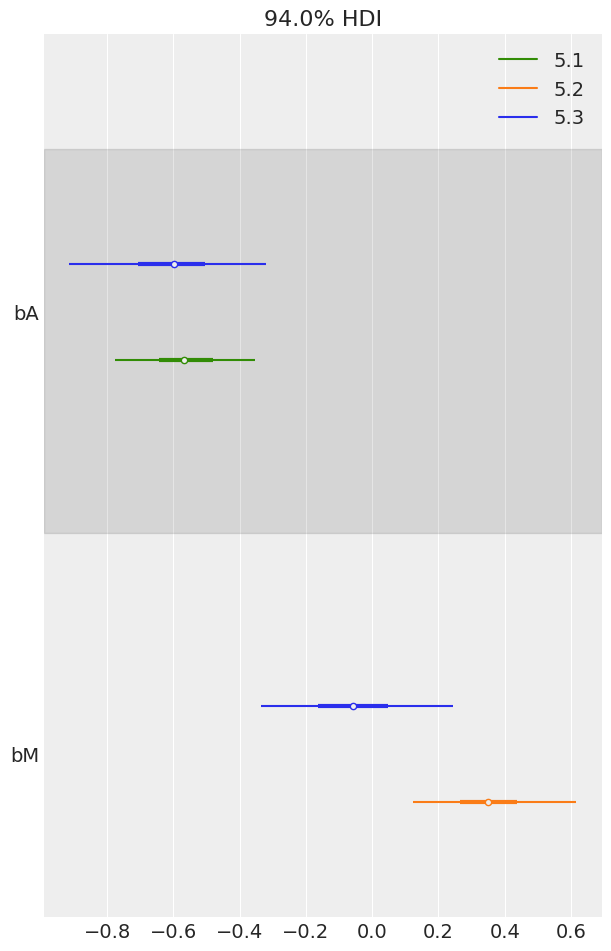

In [ ]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["bA", "bM"],
    combined=True,
);

From the distributions displayed in the graph, we can interpret it as:

> *Once we know the median age of marriage for a State, there is little or no additional predictive power in also understanding the rate of marriage in that State.* Therefore, we can say that the divorce rate is independent of the marriage rate, after conditioning on the median age of marriage: $D \perp\kern-5pt\perp M \mid A $

These findings therefore validate the DAG on the <u>right</u> in `Code 5.8` and we no longer have to consider the DCG on the left.

Also, notice in the graph how the distribution and mean for median age `bA` hardly changes between model `5.1` to `5.3` except for the small increase in uncertainty in `5.3`. On the other hand, the marriage rate, `bM`, has little predictive power over the divorce rate seeing as how the average of its distribution of the slope in model `5.3` is so close to 0 when median age is in the mix.

However, as we see in model `5.2`, it does hold some predictive power when it's the only predictor variable for the divorce rate in a simple Linear model. So from these results, you can conclude that marriage rate, $M$, does at least have some predictive power over divorce rate, $D$, but is limited to scenarios where you don't have access to other causal variables such as median age, $A$.

Therefore, marriage rate, $M$, is considered to be a *predictive* variable, but not a causal one. We can consider the relationship between marriage rate and divorce to be a **spurious relationship** as they're both influenced by the median age of marriage.

#### 5.12

In [ ]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

In [ ]:
print(f"Average median age of marriage rate (std) across all fifty states: {age.mean()}, \n \
Average marriage rate (std): {mar.mean()}, \n \
Average divorce rate (std): {div.mean()}")

Average median age of marriage rate (std) across all fifty states: -0.11546482294680137, 
 Average marriage rate (std): 0.1968964774061295, 
 Average divorce rate (std): -0.2827084065554545


### 5.1.5. Plotting multivariate posteriors.

With all that we have going on in terms of having three distributions to work with which are the y-intercept and our two predictor variables, two simple Bayesian linear regression models, one multi-linear regression model, and two DAGs, it's easy to get confused and follow along from the last few sections. With our simple Linear Model, at least it was easy to understand the relationship between the predictor (IV) and the target variable (DV) but this isn't as easy when trying to understand multiple linear regressions. Some general tips for plotting *specifically* linear regression include using:

1. **Predictor residual plots** for understanding the statistical model only;
2. **Posterior prediction plots** which show our model's prediction against the raw data and are very useful for evaluating our model. Posterior prediction plots can help us display the errors in our prediction and check our model's predictive fit but please note that they are *not causal tools.*
3. **Counterfactual plots** which are the opposite of posterior prediction plots as they're meant to display the implied (or simulated) predictions from imaginary experiments and show the causal implications of manipulating our variables.

#### 5.1.5.1. Predictor residual plots.

**Predictor residual** is the average prediction error of all the predictor variables (IV) we used to model the target variable (DV). A prediction error is simply the difference between the target variable, $y_i$, and the predicted value, $\hat{y}$: $( y_i - \hat{y} )^2 $

Generally one of the best metrics for evaluating the preformance of a Multi-Linear Regression model is **R-squared** which measures the amount of variance captured in a model and is the quotient of the model's **residual sum of squares** and its **total sum of squares**. An $R^2$ of 1 means that a model has captured all the variance in the dataset and can also be a sign of overfitting. Here's the equation for $R^2$:

$ R^2 = \frac{SS_{resid}}{SS_{total}} = \frac{\sum_{i=1}^n (y_i - \hat{y})^2}{\sum_{i=1}^n (y_i - \bar{y})^2} $

$Where$:
- $\hat{y}$ refers to the predicted value
- $\bar{y}$ refers to the average value

#### 5.13

Now let's build a **bivariate regression model** that has already been conditioned on all the other predictors and plotted against the outcome. In our new model for divorce rate, we can calculate the residual for one of our two predictor variables by using the other in our model. With our example below, we'll be modelling the marriage rate, $M$, using median age, $A$, as one of the priors:

$ D_i \sim \text{Normal}(\mu_i, \sigma) $

$ \mu_i = \alpha + \beta A_i $

$ \alpha \sim \text{Normal}(0, 0.2) $

$ \beta \sim \text{Normal}(0, 0.5) $

$ \sigma \sim \text{Exponential}(1) $

In [ ]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"].values)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()

Output()

Output()

#### Figure 5.4. Understanding multiple regression through residuals.

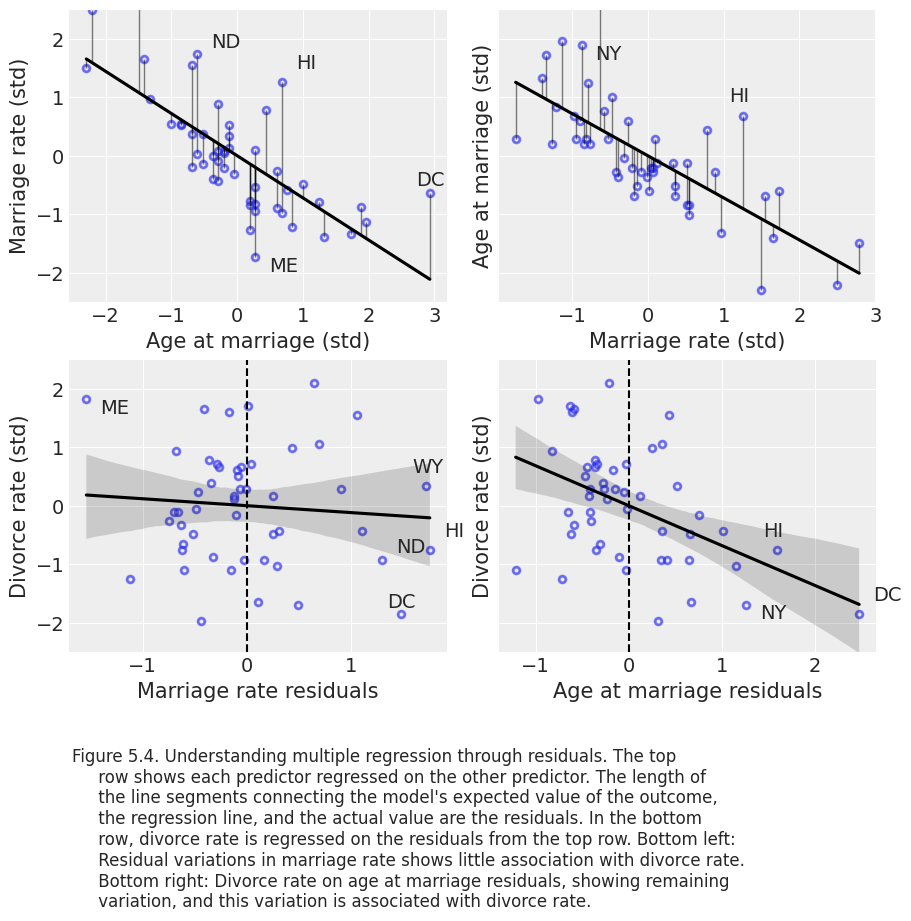

In [ ]:
#####################
### CODE ADDITION ###
#####################

# Create a custom axis object
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(9, 7))



################
### Plot 1.1 ###
################
# Fitting a linear regression to get predictions
x_vals = data["MedianAgeMarriage_std"]
y_vals = data["Marriage_std"]

X = x_vals.values.reshape(-1, 1)
reg = LinearRegression().fit(X, y_vals)
y_pred = reg.predict(X)

# Calculate residuals
residuals = y_vals - y_pred
abs_residuals = abs(residuals)

# Find indices of 5 largest residuals
top_5_indices = abs_residuals.nlargest(5).index

# Plot the first Linear Regression
sns.regplot(x="MedianAgeMarriage_std", y="Marriage_std", data=data, ax=axes[0, 0], scatter_kws={"alpha": 0.5}, line_kws={"color": "black"}, marker="$\circ$", ci=None)

# Add vertical lines connecting points to regression line
for x, y_actual, y_predicted in zip(x_vals, y_vals, y_pred):
    axes[0, 0].vlines(x=x, ymin=min(y_actual, y_predicted),
                      ymax=max(y_actual, y_predicted),
                      color='black', linestyles='-', alpha=0.5, linewidth=1)

# Add annotations for top 5 residuals with manual offsets
offsets = [(10, 10), (-10, 10), (10, -10), (-10, 5), (10, 5)]  # Different offset positions
for idx, offset in zip(top_5_indices, offsets):
    axes[0, 0].annotate(data.loc[idx, "Loc"],
                        xy=(x_vals[idx], y_vals[idx]),
                        xytext=offset,
                        textcoords='offset points',
                        fontsize=axes[0, 0].get_xticklabels()[0].get_fontsize())

axes[0, 0].set_xlabel("Age at marriage (std)")
axes[0, 0].set_ylabel("Marriage rate (std)")



################
### Plot 1.2 ###
################
# Now plotting the same graph but the predictor variable is reversed:
y_vals_2 = data["MedianAgeMarriage_std"]
x_vals_2 = data["Marriage_std"]

X_2 = x_vals_2.values.reshape(-1, 1)
reg_2 = LinearRegression().fit(X_2, y_vals_2)
y_pred_2 = reg_2.predict(X_2)

# Calculate residuals
residuals_2 = y_vals_2 - y_pred_2
abs_residuals_2 = abs(residuals_2)


# Find indices of 5 largest residuals
top_3_indices = abs_residuals_2.nlargest(3).index

# Plot the second Linear Regression
sns.regplot(y="MedianAgeMarriage_std", x="Marriage_std", data=data, ax=axes[0, 1], scatter_kws={"alpha": 0.5}, line_kws={"color": "black"}, marker="$\circ$", ci=None)

# Add vertical lines connecting points to regression line
for x, y_actual, y_predicted in zip(x_vals_2, y_vals_2, y_pred_2):
    axes[0, 1].vlines(x=x, ymin=min(y_actual, y_predicted),
                      ymax=max(y_actual, y_predicted),
                      color='black', linestyles='-', alpha=0.5, linewidth=1)

# Add annotations for top 5 residuals with manual offsets
offsets = [(10, 10), (-10, 10), (10, -10), (-10, 5), (10, 5)]  # Different offset positions
for idx, offset in zip(top_3_indices, offsets):
    axes[0, 1].annotate(data.loc[idx, "Loc"],
                        xy=(x_vals_2[idx], y_vals_2[idx]),
                        xytext=offset,
                        textcoords='offset points',
                        fontsize=axes[0, 1].get_xticklabels()[0].get_fontsize())

axes[0, 1].set_ylabel("Age at marriage (std)")
axes[0, 1].set_xlabel("Marriage rate (std)")



################
### Plot 1.3 ###
################
# Plotting the residual variation in marriage rate
data["Marriage_Resids"] = residuals
y_vals_3 = data["Divorce_std"]
x_resid_marr = data["Marriage_Resids"]

X_3 = x_resid_marr.values.reshape(-1, 1)
reg_3 = LinearRegression().fit(X_3, y_vals_3)
y_pred_3 = reg_3.predict(X_3)

# Plot the third Linear Regression
sns.regplot(y="Divorce_std", x="Marriage_Resids", data=data, ax=axes[1, 0], scatter_kws={"alpha": 0.5}, line_kws={"color": "black"}, marker="$\circ$")

# Add annotations for top 5 residuals with manual offsets
offsets = [(10, 10), (-10, 10), (10, -10), (-10, 5), (10, 5)]  # Different offset positions
for idx, offset in zip(top_5_indices, offsets):
    axes[1, 0].annotate(data.loc[idx, "Loc"],
                        xy=(x_resid_marr[idx], y_vals_3[idx]),
                        xytext=offset,
                        textcoords='offset points',
                        fontsize=axes[1, 0].get_xticklabels()[0].get_fontsize())

axes[1, 0].vlines(x=0, ymin=-2.5, ymax=2.5, ls="--", color="black")
axes[1, 0].set_ylim([-2.5, 2.5])
axes[1, 0].set_ylabel("Divorce rate (std)")
axes[1, 0].set_xlabel("Marriage rate residuals")



################
### Plot 1.4 ###
################
# Plotting the residual variation in marriage rate
data["MedianAge_Resids"] = residuals_2
y_vals_4 = data["Divorce_std"]
x_resid_age = data["MedianAge_Resids"]

X_4 = x_resid_age.values.reshape(-1, 1)
reg_4 = LinearRegression().fit(X_4, y_vals_4)
y_pred_4 = reg_3.predict(X_4)

# Plot the third Linear Regression
sns.regplot(y="Divorce_std", x="MedianAge_Resids", data=data, ax=axes[1, 1], scatter_kws={"alpha": 0.5}, line_kws={"color": "black"}, marker="$\circ$")

# Add annotations for top 5 residuals with manual offsets
offsets = [(10, 10), (-10, 10), (10, -10), (-10, 5), (10, 5)]  # Different offset positions
for idx, offset in zip(top_3_indices, offsets):
    axes[1, 1].annotate(data.loc[idx, "Loc"],
                        xy=(x_resid_age[idx], y_vals_4[idx]),
                        xytext=offset,
                        textcoords='offset points',
                        fontsize=axes[1, 1].get_xticklabels()[0].get_fontsize())

axes[1, 1].vlines(x=0, ymin=-2.5, ymax=2.5, ls="--", color="black")
axes[1, 1].set_ylim([-2.5, 2.5])
axes[1, 1].set_ylabel("Divorce rate (std)")
axes[1, 1].set_xlabel("Age at marriage residuals")



plt.suptitle(
    x=0.45,
    y=-0.06,
    t="Figure 5.4. Understanding multiple regression through residuals. The top \n \
    row shows each predictor regressed on the other predictor. The length of \n \
    the line segments connecting the model's expected value of the outcome, \n \
    the regression line, and the actual value are the residuals. In the bottom \n \
    row, divorce rate is regressed on the residuals from the top row. Bottom left: \n \
    Residual variations in marriage rate shows little association with divorce rate. \n \
    Bottom right: Divorce rate on age at marriage residuals, showing remaining \n \
    variation, and this variation is associated with divorce rate.",
    ma="left"
  )

plt.show()

#### 5.14

Let's quickly go through each graph in `Figure 5.4`.

1. On the top left (plot 1.1), we can see a negative corollary relationship between the median age of marriage ($A$) as the predictor and marriage rate ($M$) as the target variable, both standardized. The thin black lines between the blue bubble and the regression line visualize the residual.

2. On the top right (plot 1.2), we see the marriage rate and the median age of marriage having switched places as the predictor and target variable respectively. The graph still shows how variations in median age ($A$) still impact the marriage rate ($M$) and vice versa, but here we get a slightly different perspective of the relationship.

3. Now the bottom left plot (1.3) graphs how the leftover variation between marriage rates ($y_{i}$) values and the predicted value ($\hat{y}$) from median age ($A$) being the sole predictor has any predictive value over the divorce rate. The grey "shadow" hugging the regression line is the confidence interval. Based on the graph, we can see that there seems to be a weak relationship between the marriage rate residuals ($M$) and the divorce rate ($D$).

4. Lastly, the bottom right plot (1.4) visualizes the relationship between the divorce rate ($D$) and the residuals/variation of the true values for the median age of marriage ($A$) and its predicted value where the marriage rate ($M$) was the sole independent variable. In this case, the slope between median age residuals predicting the divorce rate was much steeper, indicating a stronger relationship between the two variables.

When a residual is positive, that means that the observed rate exceeds what the model expects. On the other hand, when a residual is negative, that means the observed rate was lower than what the model expected. Zooming out from a research perspective, what the models show is that states with positive residuals have higher marriage rates for their median age while states with negative residuals are the opposite with lower marriage rates for their median age.

There's conceptual value in plotting the model-based predictions against the outcome after isolating each independent variable to see their effects separately from the dependent variable. When these calculations happen automatically under a multivariate model, we won't be able to "see" these effects separately.

In [ ]:
mu_m_5_4_mean = m_5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data["Marriage_std"] - mu_m_5_4_mean

#### 5.1.5.2. Posterior prediction plots.

When building a model, we must always remember to check the model's predictions against the observed data to see whether it correctly approximates the posterior distribution. Do note however that not all models try to match the sample on hand.

It's also important to see how a model fails to get an idea of how to better improve it. In this case, it's up to the golem engineer to use their creativity and domain expertise to make these improvements and investigate what the potential issues underlying the data could be.

#### 5.15

In [ ]:
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(m_5_3_trace, var_names=["mu", "divorce_rate_std"])


mu_mean = m_5_3_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive["mu"], 0.89)

D_sim = m_5_3_ppc.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"])
D_PI = az.hdi(m_5_3_ppc.posterior_predictive["divorce_rate_std"], 0.89)

Output()

#### 5.16

#### Figure 5.5. Posterior predictive plot for the multivariate divorce model.

<ipython-input-45-cf218f4d9cde>:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "C0o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


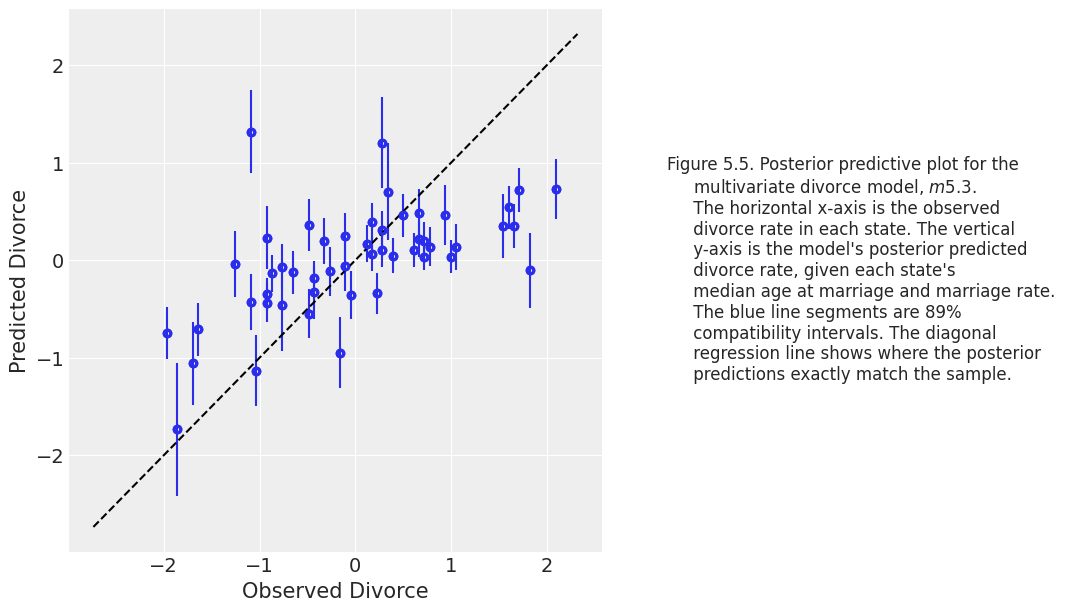

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    D_sim,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
    marker="$\circ$"
)
ax.scatter(data["Divorce_std"].values, D_sim, marker="$\circ$")

# min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
min_x, max_x = D_sim.min()-1, D_sim.max()+1
ax.plot([min_x, max_x], [min_x, max_x], "k--")
plt.suptitle(
    x=1.43,
    y=0.75,
    t="Figure 5.5. Posterior predictive plot for the \n \
    multivariate divorce model, $m5.3$. \n \
    The horizontal x-axis is the observed \n \
    divorce rate in each state. The vertical \n \
    y-axis is the model's posterior predicted \n \
    divorce rate, given each state's \n \
    median age at marriage and marriage rate. \n \
    The blue line segments are 89% \n \
    compatibility intervals. The diagonal \n \
    regression line shows where the posterior \n \
    predictions exactly match the sample.",
    ma="left"
  )
ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

Based on our plot in `Figure 5.5`, we can see that the model under-predicts for states with high divorce rates while it over-predicts for states with low divorce rates which is normal. This is very apparent at the `0.5` standardized observed divorce rate value on the x-axis showing a clear separation where any values to the right of it tended to fall below the regression line indicating an under-prediction while to the left. Regressions tend to be skeptical of extreme values and expect a regression towards the mean.

#### 5.17

In [ ]:
data["residuals"] = data["Divorce_std"] - mu_mean
data["abs_residuals"] = abs(data["Divorce_std"] - mu_mean)
data["mu_mean"] = mu_mean

In [ ]:
data.sort_values("abs_residuals", ascending=False).head(15)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,...,PropSlaves1860,WafHouse_per_million,Divorce_std,Marriage_std,MedianAgeMarriage_std,Marriage_Resids,MedianAge_Resids,residuals,abs_residuals,mu_mean
12,Idaho,ID,1.57,23.2,25.8,1.84,7.7,1.05,0,0,...,0.000000,0.000000,-1.091819,1.497141,-2.294894,-0.157698,-1.215312,-2.388043,2.388043,1.296223
19,Maine,ME,1.33,26.4,13.5,1.40,13.0,1.48,0,0,...,0.000000,0.000000,1.818967,-1.741486,0.278218,-1.540865,-0.977561,1.886505,1.886505,-0.067538
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,...,0.260000,14.041096,2.093569,1.655123,-1.410387,0.638098,-0.216885,1.339263,1.339263,0.754306
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,...,0.450000,26.778243,1.654205,0.022644,-0.606290,-0.414549,-0.589961,1.290388,1.290388,0.363817
29,New Jersey,NJ,8.79,27.7,14.8,0.59,6.1,0.46,0,0,...,0.000027,0.000000,-1.970547,-1.399192,1.323544,-0.444790,0.314593,-1.253612,1.253612,-0.716935
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,...,0.000000,0.000000,1.544364,1.549802,-0.686699,1.054626,0.430856,1.219951,1.219951,0.324413
23,Minnesota,MN,5.30,26.3,15.3,0.77,7.4,0.60,0,0,...,0.000000,0.000000,-1.256581,-1.267541,0.197808,-1.124902,-0.716211,-1.210220,1.210220,-0.046361
33,North Dakota,ND,0.67,25.3,26.7,2.93,8.0,1.44,0,0,...,0.000000,0.000000,-0.927058,1.734114,-0.606290,1.296921,0.644173,-1.192430,1.192430,0.265372
17,Kentucky,KY,4.34,24.8,22.2,1.11,12.6,0.75,64,1,...,0.000000,14.746544,1.599285,0.549250,-1.008338,-0.177859,-0.612276,1.023563,1.023563,0.575722
35,Oklahoma,OK,3.75,24.4,23.8,1.29,12.8,1.01,16,0,...,0.000000,4.266667,1.709126,0.970535,-1.329977,0.011494,-0.630128,0.963881,0.963881,0.745245


In [ ]:
# Create figure
fig = px.scatter(data, x='Divorce_std', y=mu_mean, hover_data=["Loc", "residuals", "abs_residuals"])

# Add regression line
fig.add_scatter(
    x=[i for i in np.arange(min_x, max_x, 0.1)],
    y=[i for i in np.arange(min_x, max_x, 0.1)],
    mode='lines',
    line=dict(color='black')
  )

fig.update_traces(patch={"line": {"dash": "longdash"}})

# Identify the top 10 points with the highest abs_residuals
top_points = data.nlargest(5, 'abs_residuals')

# Add scatter points with different color for the top 10
fig.add_scatter(
    x=top_points['Divorce_std'],
    y=top_points['mu_mean'],
    mode='markers',
    marker=dict(color='red', size=10),
    name='Top 10 High Residuals',
    hovertext=top_points['Loc'],
    hoverinfo='text'
  )

# Updating the formatting in the plot
fig.update_layout(
    showlegend=False,
    xaxis_title='Observed Divorce Rate Standardized',
    yaxis_title='Predicted Divorce Rate Standardized'
  )

fig.show()

If we examine states like Idaho (ID) and Utah (UT), you'll notice that they're both quite far from the regression line and seem to have much lower divorce rates than what the model expects. What we might be able to add is that both these states have a significant proportion of the Church of Jesus Christ of Latter-day Saints community within their demographic makeup. While church membership or religious beliefs weren't variables that were captured in the data, it illustrates that there are variables outside our dataset that could perhaps provide greater predictive power over our target variable which we could look to add in future iterations of this project.

#### Rethinking: Stats, huh. Yeah? What is it good for?

Often people want statistical modelling to do things that it cannot do, such as modelling whether an effect is "real" or spurious. Unfortunately, modelling merely quantifies uncertainty in the precise way that the model understands the problem. Answers to large world problems about "truth" and "causation" often depend on information not included in the model. For example, any observed correlation between a target and a predictor variable could be either eliminated or reversed when another predictor is added to the model. But if we cannot think of the right variable, we might never notice. Therefore, all statistical models are vulnerable, regardless of the precision of their estimates and the apparent accuracy of their predictions. Rounds of model criticism and revision embody the real tests of scientific hypotheses. A true hypothesis will pass and fail many statistical "tests" on its way to acceptance.

#### 5.18

##### Overthinking: Simulating spurious association.

One way that spurious associations between a predictor and a target can arise is when a truly causal predictor, let's call it $x_{real}$, influences both the target variable, $y$, and a spurious predictor, $x_{spur}$. This can be confusing to grasp so let's first simulate the data to exhibit how multiple regression models can reliably identify $x_{real}$ which is the real predictor in this simulation.

From our simulated data, we can see that `x_real` influences both `y` and `x_spur` so in a way, you can think of `x_spur` as an outcome of `x_real`, as well as a (mistaken) predictor of `y`. Because `x_real` and `x_spur` seem to have a relationship with `y` where the data seems to drift to the top right as we move along the x-axis, we can infer that they are both at least correlated to `y`. However, if we were to build a linear regression that predicts `y` using both `x_` variables, we'll find that the posterior mean (otherwise what we also like to call the "weight") for the association between `y` and `x_spur` will be close zero just like what we saw when exploring the relationship between divorce rate and marriage rate.

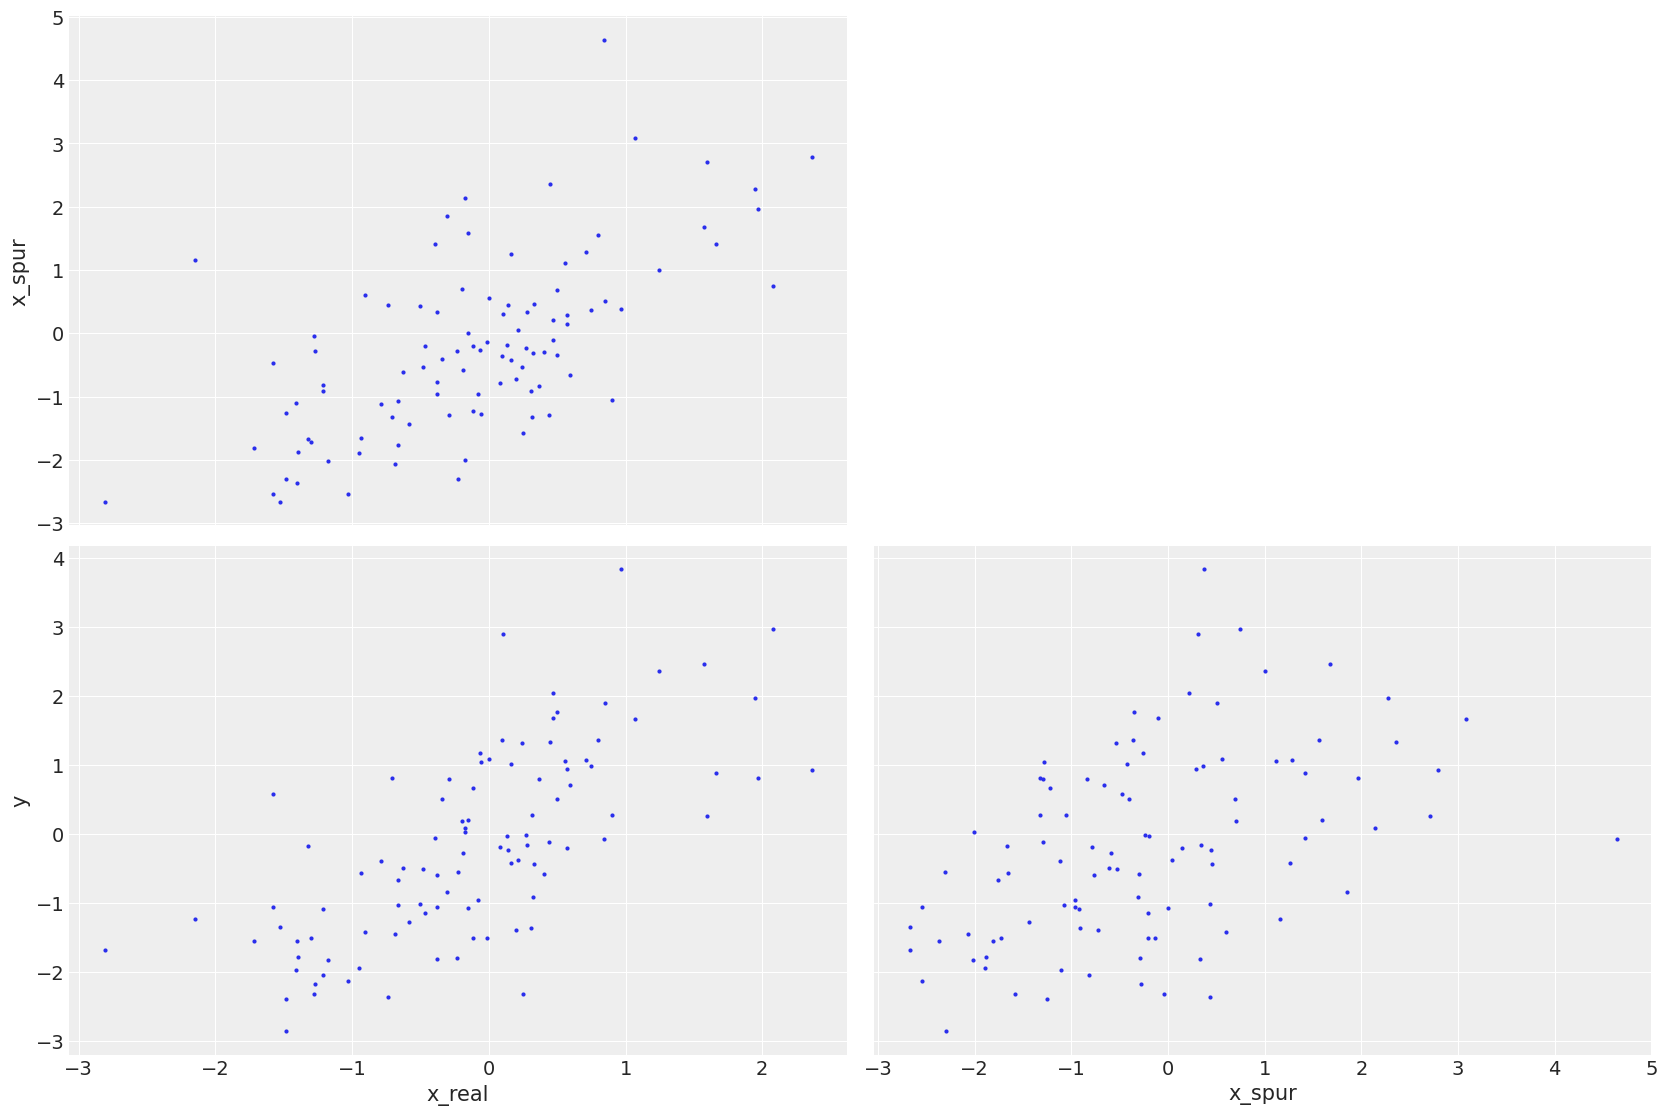

In [ ]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y});

#### 5.1.5.3. Counterfactual plots.

Another plot to display the causal implications of a model is called a **counterfactual** plot which can be produced by inputting any combination of predictor variables, even ones we haven't yet encountered from the dataset, and observing how it would influence the prediction. For example, if we asked the question: "What would Hawaii's divorce rate be if its median age of marriage were higher?"

**Counterfactuals** help us better understand a model by manipulating the predictor variables and seeing how much it affects the model's output. Now with that out of the way, let's parse the basic recipe for generating plots of model predictions that take the causal structure into account:

1. Pick a variable to manipulate which is our intervention variable;
2. Define the range of values to set the intervention variable to;
3. For each value of the intervention variable, and for each sample in the posterior, use the causal model to simulate the values of other variables, including the target variable.

The end of this process results in a posterior distribution of counterfactual outcomes that we can plot and summarize.

To simulate this process, we'll use the Gaussian distributions for each variable in model `m_5_3`. However unlike last time where model `m_5_3` ignored the assumption that $A$ influences $M$, we'll factor that into our model this time to understand the consequences of manipulating $A$. Our model `m5_3_A` will account for the influence that $A$ has on $M$ by building a simple linear regression model between $A$ and $M$ and adding the results to a multiple linear regression model.

#### 5.19

Now let's simulate what would happen if we used different parameter values for the median age and how it would predict on marriage rate. The median age parameters range from being two standard deviations below and above the mean:

In [ ]:
# data["Divorce_std"] = standardize(data["Divorce"])
# data["Marriage_std"] = standardize(data["Marriage"])
# data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Using numpy arrays which can be modified
marriage_shared = data["Marriage_std"].values
age_shared = data["MedianAgeMarriage_std"].values

In [ ]:
# with pm.Model() as m5_3_A:
#     # A -> D <- M
#     sigma = pm.Exponential("sigma", 1)
#     bA = pm.Normal("bA", 0, 0.5)
#     bM = pm.Normal("bM", 0, 0.5)

#     a = pm.Normal("a", 0, 0.2)
#     mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
#     divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

#     # A -> M
#     sigma_M = pm.Exponential("sigma_m", 1)
#     bAM = pm.Normal("bAM", 0, 0.5)
#     aM = pm.Normal("aM", 0, 0.2)
#     mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
#     marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"].values)

#     m5_3_A_trace = pm.sample()


with pm.Model() as m5_3_A:
   # Priors
   sigma = pm.Exponential('sigma', lam=1)
   bM = pm.Normal('bM', mu=0, sigma=0.5)
   bA = pm.Normal('bA', mu=0, sigma=0.5)
   a = pm.Normal('a', mu=0, sigma=0.2)

   sigma_M = pm.Exponential('sigma_M', lam=1)
   bAM = pm.Normal('bAM', mu=0, sigma=0.5)
   aM = pm.Normal('aM', mu=0, sigma=0.2)

   # A -> M path
   mu_M = pm.Deterministic("mu_m", aM + (bAM * age_shared)) # sim_data['A']
   marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"].values)

   # A -> D <- M path
   mu = pm.Deterministic("mu", a + (bM * marriage_shared) + (bA * age_shared)) # sim_data['A']
   divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

   # Sample from the model
   m5_3_A_trace = pm.sample(1000, tune=1000)

   # Simulate new values
   posterior_predictive = pm.sample_posterior_predictive(
       m5_3_A_trace,
       var_names=['marriage', 'divorce']
   )

Output()

Output()

Output()

From our summary table and graph, we can see that the median age, $B_A$, parameter `b_AM` in the simple linear regression model is strongly negatively associated with the marriage rate, $M$, parameter, `mu_M`.

In [ ]:
az.summary(m5_3_A_trace, var_names=["a", "bM", "bA", "sigma", "aM", "bAM", "sigma_M"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.098,-0.180,0.179,0.002,0.002,2383.0,1457.0,1.0
bM,-0.061,0.156,-0.368,0.229,0.003,0.003,2054.0,1680.0,1.0
bA,-0.605,0.157,-0.911,-0.333,0.003,0.002,2146.0,1426.0,1.0
sigma,0.825,0.087,0.682,1.000,0.002,0.001,2172.0,1471.0,1.0
aM,0.000,0.090,-0.156,0.186,0.002,0.002,2396.0,1464.0,1.0
bAM,-0.693,0.097,-0.870,-0.510,0.002,0.001,2594.0,1462.0,1.0
sigma_M,0.709,0.073,0.575,0.841,0.001,0.001,2439.0,1537.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

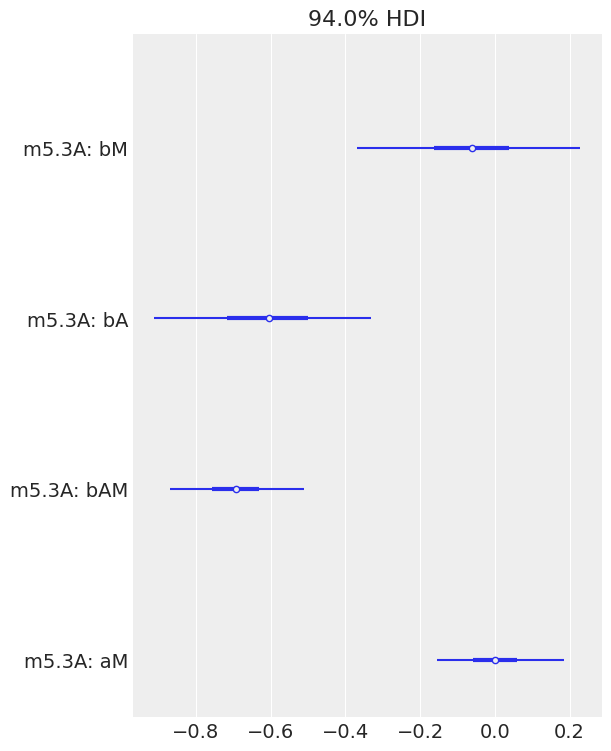

In [ ]:
az.plot_forest(
    m5_3_A_trace,
    model_names=["m5.3A"],
    var_names=["bM", "bA", "bAM", "aM"],
    combined=True,
)

#### 5.20

Next, let's simulate what would happen if we manipulated $A$ by defining a list of 50 imaginary interventions ranging from 2 standard deviations below and above the mean.

In [ ]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
print(A_seq.shape)

# Create DataFrame
sim_data = pd.DataFrame({'A': A_seq})

(50,)


#### 5.21

With our simulated marriage rate data, $A$, we'll now use it to manipulate the marriage rate, $M$, then the divorce rate, $D$, in that respective order so that we can observe the influence of $A$ on $M$ before observing their effect on $D$.

In [ ]:
# With PyMC we have to simulate in each model separately

# Simulate the marriage rates at each age first
# with m5_3_A:
#     m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)


# Now simulate new observations using A_seq
with m5_3_A:
    # First simulate M values for each A in A_seq
    mu_M = aM + bAM * sim_data['A']
    M = pm.Normal('M_sim_A', mu=mu_M, sigma=sigma_M)

    # Then simulate D values using simulated M and A_seq
    mu = a + bM * M + bA * sim_data['A']
    D = pm.Normal('D_sim_A', mu=mu, sigma=sigma)

    # Generate samples from the posterior predictive distribution
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace,
        var_names=['M_sim_A', 'D_sim_A']
    )

Output()

In [ ]:
az.summary(m5_3_M_marriage)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1357: UserWarning:

Selecting first found group: posterior_predictive



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D_sim_A[0],1.090,0.875,-0.617,2.620,0.021,0.015,1732.0,1816.0,1.0
D_sim_A[1],1.072,0.894,-0.700,2.628,0.021,0.015,1803.0,1926.0,1.0
D_sim_A[2],1.029,0.858,-0.529,2.603,0.019,0.014,1995.0,1885.0,1.0
D_sim_A[3],1.003,0.849,-0.603,2.597,0.019,0.014,1945.0,1924.0,1.0
D_sim_A[4],0.988,0.849,-0.732,2.477,0.021,0.016,1596.0,1849.0,1.0
...,...,...,...,...,...,...,...,...,...
M_sim_A[45],-1.198,0.733,-2.609,0.137,0.016,0.011,2043.0,1850.0,1.0
M_sim_A[46],-1.213,0.733,-2.554,0.179,0.016,0.011,2063.0,1942.0,1.0
M_sim_A[47],-1.244,0.738,-2.677,0.072,0.016,0.012,2076.0,1926.0,1.0
M_sim_A[48],-1.336,0.753,-2.714,0.113,0.017,0.012,2059.0,1851.0,1.0


#### 5.22

From the resulting graph in `Figure 5.6`, we can observe the small effect of $M → D$ since the shape of the slopes between the two graphs hardly change much when we switch the target variable (i.e. switching divorce rate, $D$, on the left with marriage rate, $M$, on the right) that median age, $A$, (our predictor variable) is trying to predict for.

If the marriage rate, $M$, did indeed have a large effect on the divorce rate, $D$, then any visible difference between the two graphs would have been much more noticeable.

#### Figure 5.6. Conterfactual plots for the multivariate divorce model, `m5_3_M`.

Text(0.4, -0.06, 'Figure 5.6. Counterfactual plots for the multivariate divorce model, $m5.3$. \n     These plots visualize the predicted effect of manipulating age at marriage A on divorce rate D. \n     Left: Total causal effect of manipulating A (horizontal) on D. This plot contains both paths, A --> D \n     and A --> M --> D.  Right: Simulated values of M show the estimated influence A --> M.')

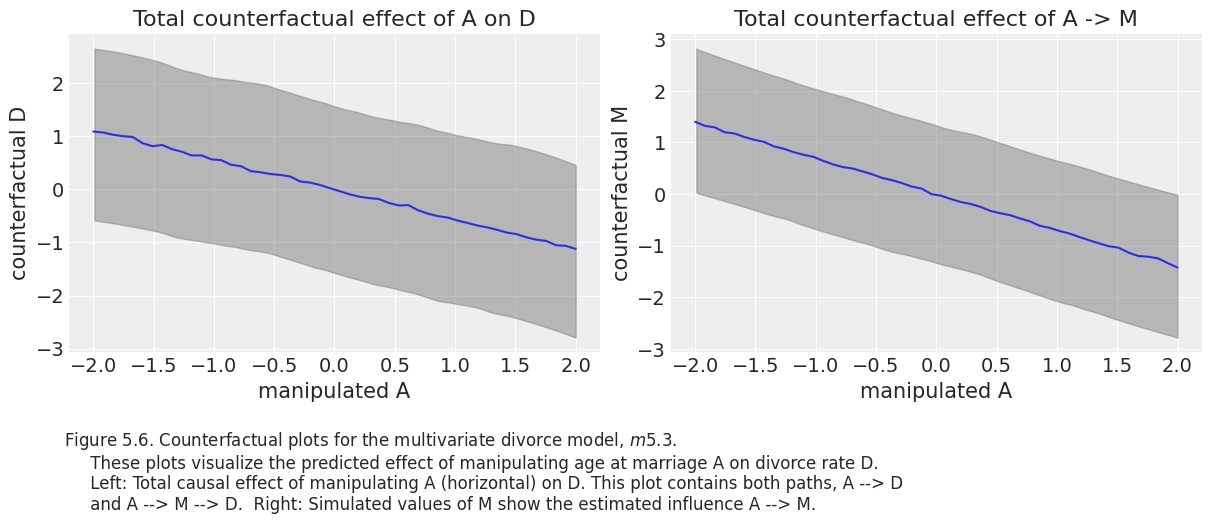

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["D_sim_A"], ax=ax[0], color="grey")
ax[0].plot(A_seq, m5_3_M_marriage.posterior_predictive["D_sim_A"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["M_sim_A"], ax=ax[1], color="grey")
ax[1].plot(A_seq, m5_3_M_marriage.posterior_predictive["M_sim_A"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M")

plt.suptitle(
    x=0.4,
    y=-0.06,
    t="Figure 5.6. Counterfactual plots for the multivariate divorce model, $m5.3$. \n \
    These plots visualize the predicted effect of manipulating age at marriage A on divorce rate D. \n \
    Left: Total causal effect of manipulating A (horizontal) on D. This plot contains both paths, A --> D \n \
    and A --> M --> D.  Right: Simulated values of M show the estimated influence A --> M.",
    ma="left"
  )

#### 5.23

These calculations also permit numerical summaries such as the expected causal effect of increasing the median age at marriage, $A$, from 20 to 30:

In [ ]:
az.summary(m5_3_A_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.098,-0.180,0.179,0.002,0.002,2383.0,1457.0,1.0
aM,0.000,0.090,-0.156,0.186,0.002,0.002,2396.0,1464.0,1.0
bA,-0.605,0.157,-0.911,-0.333,0.003,0.002,2146.0,1426.0,1.0
bAM,-0.693,0.097,-0.870,-0.510,0.002,0.001,2594.0,1462.0,1.0
bM,-0.061,0.156,-0.368,0.229,0.003,0.003,2054.0,1680.0,1.0
...,...,...,...,...,...,...,...,...,...
mu_m[47],0.588,0.122,0.356,0.818,0.002,0.002,2601.0,1571.0,1.0
mu_m[48],-0.137,0.091,-0.299,0.041,0.002,0.001,2352.0,1464.0,1.0
mu_m[49],1.034,0.171,0.729,1.355,0.003,0.002,2626.0,1685.0,1.0
sigma,0.825,0.087,0.682,1.000,0.002,0.001,2172.0,1471.0,1.0


In [ ]:
A_seq_20 = (np.repeat(20, 50) - 26.1) / 1.24
sim20_data = pd.DataFrame({'A20': A_seq_20})
with m5_3_A:
    # First simulate M values for each A in A_seq_2
    mu_M_20 = aM + bAM * sim20_data['A20']
    M_20 = pm.Normal('M_sim_A_20', mu=mu_M_20, sigma=sigma_M)

    # Then simulate D values using simulated M and A_seq_2
    mu_20 = a + bM * M_20 + bA * sim20_data['A20']
    D_20 = pm.Normal('D_sim_A_20', mu=mu_20, sigma=sigma)

    # Generate samples from the posterior predictive distribution
    m5_20_M_ppc = pm.sample_posterior_predictive(
        trace=m5_3_A_trace,
        var_names=['M_sim_A_20', 'D_sim_A_20']
    )



A_seq_30 = (np.repeat(30, 50) - 26.1) / 1.24
sim30_data = pd.DataFrame({'A30': A_seq_30})
with m5_3_A:
    # First simulate M values for each A in A_seq_2
    mu_M_30 = aM + bAM * sim30_data['A30']
    M_30 = pm.Normal('M_sim_A_30', mu=mu_M_30, sigma=sigma_M)

    # Then simulate D values using simulated M and A_seq_2
    mu_30 = a + bM * M_30 + bA * sim30_data['A30']
    D_30 = pm.Normal('D_sim_A_30', mu=mu_30, sigma=sigma)

    # Generate samples from the posterior predictive distribution
    m5_30_M_ppc = pm.sample_posterior_predictive(
        trace=m5_3_A_trace,
        var_names=['M_sim_A_30', 'D_sim_A_30']
    )

Output()

Output()

In [ ]:
divorce_diff20 = (
    m5_20_M_ppc.posterior_predictive["D_sim_A_20"][:, -1].mean()
    - m5_20_M_ppc.posterior_predictive["D_sim_A_20"][:, 0].mean()
)

divorce_diff30 = (
    m5_30_M_ppc.posterior_predictive["D_sim_A_30"][:, -1].mean()
    - m5_30_M_ppc.posterior_predictive["D_sim_A_30"][:, 0].mean()
)


divorce_diff = divorce_diff20 - divorce_diff30
print(f"Average difference in divorce rates: {divorce_diff:.3f} standard deviations")

Average difference in divorce rates: 0.821 standard deviations


In [ ]:
###################
### OLD CODE x2 ###
###################

# # Setting this to 50 to match the shape of our input
# # A_seq_2 = (np.linspace(20, 30, 50) - 26.1) / 1.24
# A_seq_2 = (np.repeat(30, 50) - 26.1) / 1.24

# # A new DataFrame, standardized to mean 26.1 and std dev 1.24
# sim2_data = pd.DataFrame({'A': A_seq_2})


# # age_shared.set_value(A_seq)

# # with m5_3_A:
# #     m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

# with m5_3_A:
#     # First simulate M values for each A in A_seq_2
#     mu_M_2 = aM + bAM * sim2_data['A']
#     M_2 = pm.Normal('M_sim_A_2', mu=mu_M_2, sigma=sigma_M)

#     # Then simulate D values using simulated M and A_seq_2
#     mu_2 = a + bM * M_2 + bA * sim2_data['A']
#     D_2 = pm.Normal('D_sim_A_2', mu=mu_2, sigma=sigma)

#     # Generate samples from the posterior predictive distribution
#     m5_3_M_ppc = pm.sample_posterior_predictive(
#         trace=m5_3_A_trace,
#         var_names=['M_sim_A_2', 'D_sim_A_2']
#     )

# divorce_diff = (
#     m5_3_M_ppc.posterior_predictive["D_sim_A_2"][:, -1].mean()
#     - m5_3_M_ppc.posterior_predictive["D_sim_A_2"][:, 0].mean()
# )

# print(f"Average difference in divorce rates: {divorce_diff:.3f}")

#### 5.24

The trick with simulating counterfactuals is to realize that when we manipulate some variable, such as $M$, we lose the causal influence of other variables that were in the mix. Therefore, we end up changing our DAG so that $A$ never influences $M$ and we lost the arrow between $A → M$:

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



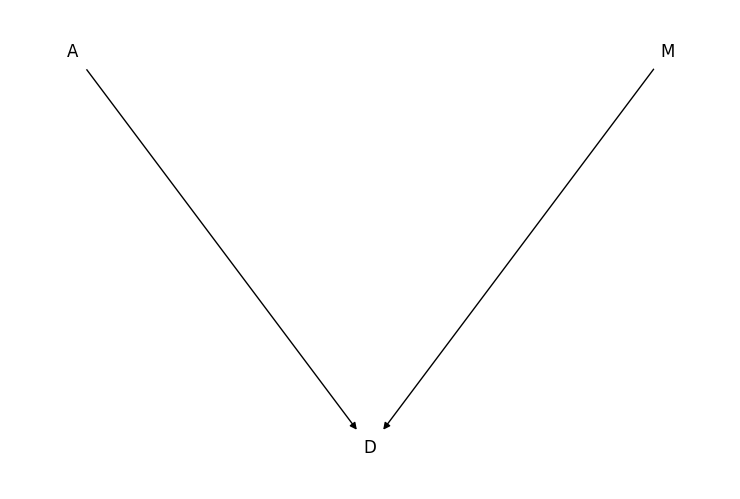

In [ ]:
# Create a directed graph
DAG3 = nx.DiGraph()

# Add nodes
DAG3.add_node("A", pos=(0, 0))
DAG3.add_node("M", pos=(1, 0))
DAG3.add_node("D", pos=(0.5, -1))

# Add edges (vertices)
DAG3.add_edge("M", "D")
DAG3.add_edge("A", "D")

# Get node positions
node_positions3 = nx.get_node_attributes(DAG3, 'pos')

# Draw the graph
nx.draw(DAG3, node_positions3, with_labels=True, node_size=1000, font_size=12, font_color='black', node_color='white')

# Display the graph
plt.show()

With the code below, we can simulate the counterfactual result of manipulating $M$ using a state where their median age fall right on the average of the distribution (i.e. where $A = 0$) to see how $M$ changes:

In [ ]:
################
### Old Code ###
################
# # Set values for marriage counterfactual
# marriage_counter_factual_x = np.linspace(-2, 2, 50)
# marriage_shared.set_value(marriage_counter_factual_x)

# # Fix age to zero
# age_shared.set_value(np.zeros(50))

# with m5_3_A:
#     m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)


################
### New Code ###
################
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_counter_factual_x_df = pd.DataFrame({'X': marriage_counter_factual_x})

# Fix age to zero
age_shared_no_effect = pd.DataFrame({'A': np.zeros(50)})

with m5_3_A:
    # First simulate M values for each X in marriage_counter_factual_x
    mu_M_counterfactual_x = aM + bAM * marriage_counter_factual_x_df['X']
    M_counterfactual_x = pm.Normal('M_sim_A_counterfactual_x', mu=mu_M_counterfactual_x, sigma=sigma_M)

    # Then simulate D values using simulated M and A_seq_2
    mu_counterfactual_x = a + (bM * M_counterfactual_x) + (bA * age_shared_no_effect['A'])
    D_counterfactual_x = pm.Normal('D_sim_A_counterfactual_x', mu=mu_counterfactual_x, sigma=sigma)

    # Generate samples from the posterior predictive distribution
    m5_3_M_ppd = pm.sample_posterior_predictive(
        m5_3_A_trace,
        var_names=['M_sim_A_counterfactual_x', 'D_sim_A_counterfactual_x']
    )

Output()

### Figure 5.7. The counterfactual effect of manipulating marriage rate on divorce rate.

Text(1.32, 0.75, 'Figure 5.7. The counterfactual effect of \n     manipulating marriage rate $M$ on divorce rate $D$. \n     Since $M$ --> $D$ was estimated to be very small, \n     there is no strong trend here. By manipulating \n     $M$, we break the influence of $A$ on $M$, and this \n     removes the association between $M$ and $D$.')

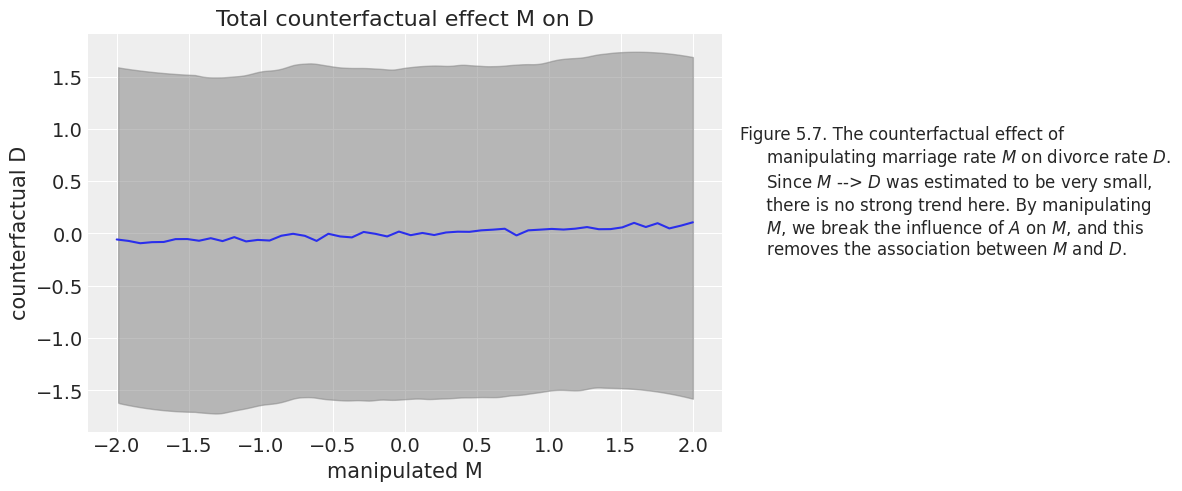

In [ ]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppd.posterior_predictive["D_sim_A_counterfactual_x"], ax=ax, color="grey")
ax.plot(
    marriage_counter_factual_x,
    m5_3_M_ppd.posterior_predictive["D_sim_A_counterfactual_x"].mean(dim=["chain", "draw"]),
)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D")

#####################
### CODE ADDITION ###
#####################
# Adding the graph explanations from the textbook
plt.suptitle(
    x=1.32,
    y=.75,
    t="Figure 5.7. The counterfactual effect of \n \
    manipulating marriage rate $M$ on divorce rate $D$. \n \
    Since $M$ --> $D$ was estimated to be very small, \n \
    there is no strong trend here. By manipulating \n \
    $M$, we break the influence of $A$ on $M$, and this \n \
    removes the association between $M$ and $D$.",
    ma="left"
  )

As we can see from `Figure 5.7`, $M$ doesn't appear to have a strong influence on $D$ when we run this counterfactual. So in an ideal world, we should just be computing for the effect that median age, $A$, has on divorce rates, $D$. However, even with more complex models, it is simply not possible to estimate this relationship without some exposure of weaker causal factors like we've seen with marriage rates, $M$. We'll return to this theme in later chapters.

### Overthinking: Simulating counterfactuals.

To recap, simulating counterfactuals is easy because we're simply taking the parameters that we've defined with model `m5_3_A` and define the range of values we want to assign to our median age, $A$, parameter:

#### 5.25

In [ ]:
A_seq_3 = np.linspace(-2, 2, 30)
sim3_data = pd.DataFrame({'A': A_seq_3})
sim3_data.shape

(30, 1)

#### 5.26

Next we'll extract the posterior samples from the inputs we fed to the $A$ parameter we defined earlier:

In [ ]:
# Get the samples from Age Marriage model first
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma_M", "aM", "bAM"]
    )

Output()

In [ ]:
marriage_mu_counterfactual = np.outer(
    m5_3_M_marriage.posterior_predictive["aM"] + m5_3_M_marriage.posterior_predictive["bAM"],
    A_seq
)

marriage_mu_counterfactual.shape

(2000, 50)

In [ ]:
mu = marriage_mu_counterfactual.T
sigma = az.extract_dataset(m5_3_M_marriage.posterior_predictive["sigma_M"]).to_array()
M_sim = stats.norm(loc=mu, scale=sigma).rvs()
M_sim.shape

(50, 2000)

In [ ]:
simulated_posterior = pd.DataFrame(M_sim)
simulated_posterior.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.330714,0.340476,1.595167,1.445849,-2.126904,-0.503549,-0.574633,-0.673577,-0.152535,5.313403,...,-1.087296,-1.067661,0.138828,0.906866,0.381896,0.985468,0.892679,1.638517,0.254575,0.892052
1,-0.297820,0.313426,3.706939,1.261717,0.244891,-1.450179,-2.233802,-0.777236,0.785268,-0.060050,...,-1.072635,-0.745132,0.074642,-0.710875,-0.077784,0.949609,1.296796,1.703616,0.300940,0.213593
2,0.422673,0.112223,-0.499350,1.280357,0.302343,-1.127384,-2.162034,-0.471262,-0.728782,-0.049913,...,-3.898620,-0.885859,-0.361076,0.620162,-0.902638,0.829647,0.736443,0.151037,0.202577,-1.479327
3,1.072349,-0.404997,-1.076763,1.482968,0.578002,-1.048503,-2.452412,-0.237469,-0.128561,-4.899106,...,-0.769060,-1.047246,0.423385,0.102459,-0.259770,0.888442,0.575214,0.593491,0.211764,0.981190
4,1.764983,-0.244016,-0.750030,1.395247,0.229011,-0.866241,-1.298774,0.995297,-1.309618,-0.560896,...,-2.600852,-0.651410,0.067194,-1.790585,-0.327064,0.715226,1.010230,0.924928,0.227097,0.008541


#### 5.27

As a result, we were able to generate a matrix of row samples corresponding to each value within the `A_seq_3` array (or `sim3_data` DataFrame). This process then just repeats itself for each parameter you've included in your model. The larger your model is, the more simulations you would have to make against the target variable.

In [ ]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma", "bM", "bA", "a"]
    )

Output()

In [ ]:
D_sim = np.zeros((50, 2000))
a = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["a"]).to_array())
bM = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bM"]).to_array())
bA = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bA"]).to_array())
sigma = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["sigma"]).to_array())

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA * age_counterfactual + bM * M_sim[i, :]
    samples = stats.norm(divorce_mu_counterfactual, sigma).rvs()
    D_sim[i, :] = samples

## *Section 5.2* - Masked Relationships


#### 5.28

With our extensive example in the divorce rate, we learned that multiple predictor variables are useful in weeding out spurious associations and measuring their influence on the target variable outcome, especially when there aren't obvious relationships apparent from building a bivariate model (i.e. a simple linear regression model). These kinds of problems tend to come up especially when the predictor variables are correlated with one another.

Now let's examine a scenario with milk composition where two predictor variables are correlated with one another but one is negatively correlated to the target variable while the other isn't.

In [ ]:
github = "https://raw.githubusercontent.com/vanislekahuna/Statistical-Rethinking-PyMC/refs/heads/main/Data/milk.csv"
d = pd.read_csv(github, delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### 5.29

From the data we just loaded into the Pandas DataFrame, the variables that stand out are the following:

- The `kcal.per.g` which is the kilocalories of *energy* per gram of milk;
- The `mass` which is the variable that measures the average female body mass in kilograms;
- The `neocortex.perc` is the percentage of total brain mass that is made up of the neocortex.

With this data, we will attempt to contribute to the discussion on whether primates with larger brains tend to produce more energetic milk, which we'll measure in `kcal.per.g`, thus enabling the brain to grow more quickly. This is still a topic debated by the evolutionary biology community largely because they don't have a reference model. Although this investigation will not lead us closer to the answer, it's still useful to illustrate the point that some variables may have a *masking effect* on other variables, thus distorting or hiding the relationships between the variables relevant to this analysis. Spoiler alert! The variable in this scenario is the `mass` that will hide the relationship between the neocortex and the energy produced in the milk.

To start, we'll first standardize all the variables in this dataset:

In [ ]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,NaN,-0.510160
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,NaN,-0.493204
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,NaN,-0.529134
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,NaN,-0.506123


#### 5.30 \(i.e. The cell where the model is meant to fail\)

Next, we'll build a simple linear regression between kilocalories of energy per gram, $K$, and neocortex, $N$, as a baseline model for comparison:

$ K_i \sim \text{Normal}(\mu_i, \sigma) $

$ \mu_i = \alpha + \beta_N N_i $


Where:

- $K$ is the standardized kilocalories of energy content per gram in milk;
- $N$ is the standardized percentage of the total brain mass that's made up of the neocortex mass

In [ ]:
##############################
### This is meant to fail! ###
##############################

# Commenting this faulty model out for now
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * d["N"].values)

    K = pm.Normal("K", mu, sigma, observed=d["K"].values)

    m5_5_draft_trace = pm.sample()

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(-0.18978759), 'bN': array(-0.22672164), 'a': array(-0.12711285)}

Logp initial evaluation results:
{'sigma': -1.02, 'bN': -0.94, 'a': -0.93, 'K': nan}
You can call `model.debug()` for more details.

With our PyMC model above, we intentionally meant for our code to return an error because of the missing values within the $N$ variable which is our percentage of neocortex mass. We can see the missing values within `Code 5.32`.

#### 5.32

In [ ]:
d["neocortex.perc"].head(10)

print(f"Of the {d.shape[0]} rows in our dataset, {d['neocortex.perc'].isna().sum()} of them or {(100 * (d['neocortex.perc'].isna().sum() / d.shape[0])):.2f}% of them have missing values.")

Of the 29 rows in our dataset, 12 of them or 41.38% of them have missing values.


#### 5.32

Unfortunately, PyMC cannot process variables with missing values, especially our target variable, so what we need to do here is simply just to drop all the cases/rows with null values. This is what's known as **complete case analysis**. We should note, however, that this process will remove a significant portion of our dataset by over 40% which is a substantial amount. In Chapter 15, we'll cover how to deal with null values in greater depth but for now, we'll continue analyzing our tiny milk dataset.

In [ ]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

#### 5.33

With our smaller DataFrame we've renamed it as `dcc` containing only 17 rows, let's now fit that Simple Linear Regression we defined earlier:

In [ ]:
# # shared_N = shared(dcc["N"].values)

# with pm.Model() as m5_5_draft:
#     sigma = pm.Exponential("sigma", 1)
#     bN = pm.Normal("bN", 0, 1)
#     a = pm.Normal("a", 0, 1)
#     mu = pm.Deterministic("mu", a + bN * shared_N)

#     K = pm.Normal("K", mu, sigma, observed=dcc["K"])

#     m5_5_draft_trace = pm.sample()

with pm.Model() as m5_5_draft:
    shared_N = pm.Data("shared_N", dcc["N"].values)  # Define shared_N using pm.Data

    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()

Output()

Output()

#### 5.34

Before looking into the predictions for the posterior distribution, let's first review whether the priors in the model are reasonable. To check, let's simulate and plot fifty regression lines with our simple linear regression model:

In [ ]:
xseq = [-2, 2]
x_seq_values = np.append(np.repeat(np.array(xseq), round((dcc.shape[0] / 2), 0)), 2)
# shared_N.set_value(np.array(xseq))

with m5_5_draft:
  pm.set_data({"shared_N": x_seq_values})  # Update shared_N using pm.set_data
  m5_5_draft_prior_predictive = pm.sample_prior_predictive()

#### Code 5.35 - A simple linear regression (`m5_5`) between neocortex % and kilocalories

In [ ]:
# shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    shared_N = pm.Data("shared_N", dcc["N"].values)  # Define shared_N using pm.Data

    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    m5_5_trace = pm.sample()

m5_5_data = az.extract_dataset(m5_5_trace)

Output()

Output()

In [ ]:
# shared_N.set_value(np.array(xseq))

with m5_5:
    pm.set_data({"shared_N": x_seq_values})
    m5_5_prior_predictive = pm.sample_prior_predictive()

#### Figure 5.8. Prior predictive distribution for the first primate milk model, `m5_5`.

Text(0.3, -0.06, 'Figure 5.8. Prior predictive distribution for the first primate milk model, \n     $m5.5$. Each plot shows a range of 2 standard deviations for each variable. \n     Left: The vague first guess. These priors are clearly silly. Right: Slightly less \n     silly priors that at least stay within the potential space of observations.')

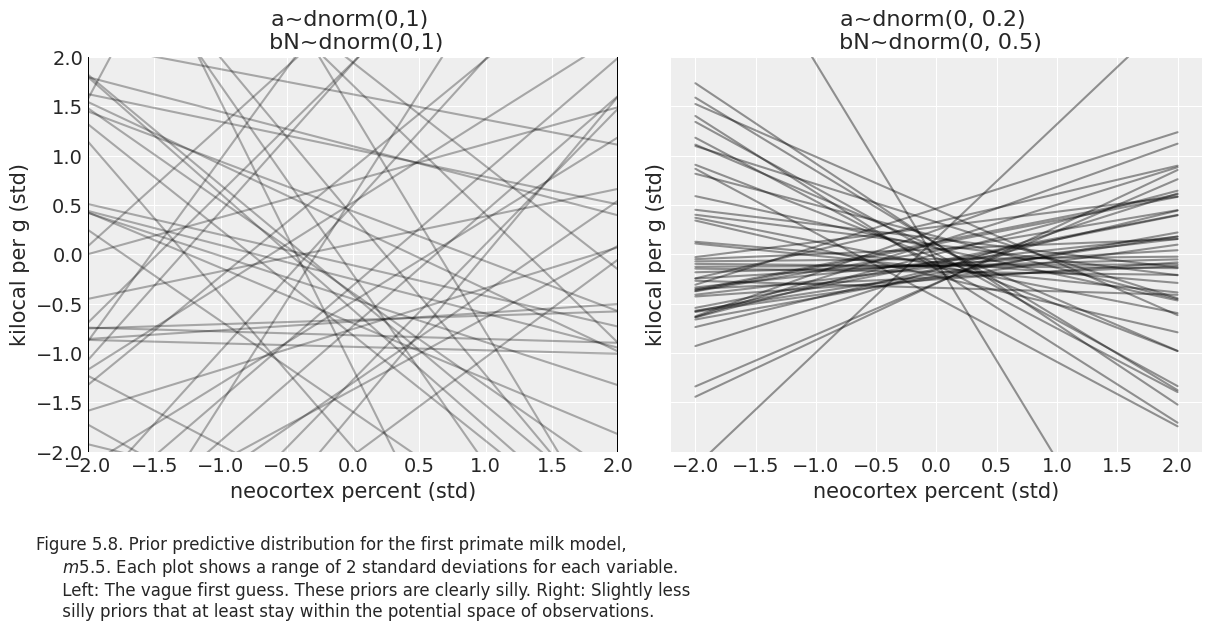

In [ ]:
# My own graph

# fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))


##################################
### Plot A - Vague first guess ###
##################################
ppr_K = m5_5_draft_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax[0].plot(x_seq_values, ppr_K[i], c="black", alpha=0.3)

ax[0].set_xlim(xseq)
ax[0].set_ylim(xseq)
ax[0].set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax[0].set_xlabel("neocortex percent (std)")
ax[0].set_ylabel("kilocal per g (std)")



##################################
### Plot B - Less silly priors ###
##################################
prior_samp_a = np.array(m5_5_prior_predictive["prior"]["a"][0][:50])
prior_samp_bN = np.array(m5_5_prior_predictive["prior"]["bN"][0][:50])
x = np.linspace(-2, 2, 50)

for a, bN in zip(prior_samp_a, prior_samp_bN):
    y = a + bN * x
    ax[1].plot(x, y, c="black", alpha=0.4)

ax[1].set_title("a~dnorm(0, 0.2) \n bN~dnorm(0, 0.5)")
ax[1].set_xlabel("neocortex percent (std)")
ax[1].set_ylabel("kilocal per g (std)")

# Adding the graph explanations from the textbook
plt.suptitle(
    x=0.3,
    y=-0.06,
    t="Figure 5.8. Prior predictive distribution for the first primate milk model, \n \
    $m5.5$. Each plot shows a range of 2 standard deviations for each variable. \n \
    Left: The vague first guess. These priors are clearly silly. Right: Slightly less \n \
    silly priors that at least stay within the potential space of observations.",
    ma="left"
  )

From `Figure 5.8`, we can see that there doesn't seem any relationship between the two variables with the loose priors in the `m5_5_draft` model on the left. However in model `m5_5` which is visualized on the right, we can see an improvement in the preformance of the model by tightening priors such as the $\alpha$ prior from $1 → 0.2$ so that it's closer to zero. The $\beta_N$ prior also got the same treatment by reducing the standard deviation of the prior distribution from $1 → 0.5$ so that the predicted values hug closer to zero when our predictor is 0.

#### 5.36

Although are priors for model `m5_5` on the right-hand side of `Figure 5.8` are still vague, at least they stay within the high probability realms of the observable data. From the summary table we produced, we can see that the model demonstrates neither strong nor precise association judging from the fact that the standard deviations for each predictor is almost twice the amount of the posterior mean.

In [ ]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.035,0.160,-0.262,0.317,0.003,0.003,2329.0,1352.0,1.0
bN,0.134,0.239,-0.329,0.565,0.005,0.005,2641.0,1601.0,1.0
sigma,1.103,0.201,0.767,1.466,0.005,0.003,2094.0,1376.0,1.0


#### 5.37

Let's now plot the 89% compatibility interval for the mean to see the output of our model more easily. From the plot below, we can see that the posterior mean regression line is weakly positive and therefore, highly imprecise. A lot of mildly positive and negative slopes are plausible here given the model and the data.

Output()

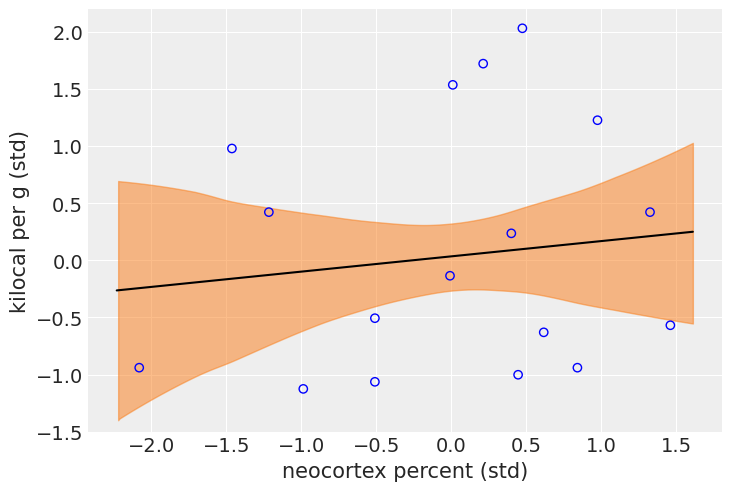

In [ ]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)
# shared_N.set_value(xseq)

with m5_5:
    pm.set_data({"shared_N": xseq})
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"])

mu_ppd_m5_5 = m5_5_posterior_predictive.posterior_predictive["mu"]
mu_mean_m5_5 = mu_ppd_m5_5.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd_m5_5, ax=ax)
ax.plot(xseq, mu_mean_m5_5, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### Code 5.38 - A bivariate linear regression (`m5_6`) between kilocalories and log(mass)

Now let's consider another predictor variable, such as the adult female body `mass`, as well as its logarithm, `log(mass)`, so that the variable relates in magnitude to other variables. By using the logarithm of the female body mass, we're baking in an assumption that we suspect the magnitude of a mother's body mass is related to the milk's energy in a linear fashion. In Chapter 16, we'll have a better understanding of why logarithms are almost inevitable results of the physics of organisms.

Let's now construct another Simple Linear Model for the relationship between kilocalories (i.e. the amount of energy produced in the milk) and body mass using their standardized forms:

In [ ]:
# Actually using the log of the body mass and then applying the standardize() function to get similar results
dcc["log(mass)"] = standardize(np.log(dcc["mass"]))
dcc[["M", "log(mass)"]]

<ipython-input-127-5e9e5c2586eb>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,M,log(mass)
0,-0.515812,-0.430154
5,-0.382588,0.082211
6,-0.377744,0.093902
7,-0.493204,-0.299552
9,-0.567082,-0.975160
10,-0.589690,-1.872525
11,-0.575560,-1.166241
12,-0.581616,-1.365110
15,-0.531960,-0.548921
17,-0.463734,-0.167482


In [ ]:
# shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    # shared_M = pm.Data("shared_M", dcc["M"].values)
    shared_M = pm.Data("shared_M", dcc["log(mass)"].values)
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

m5_6_data = az.extract_dataset(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.294,0.229,-0.752,0.113,0.004,0.004,2623.0,1480.0,1.0
a,0.040,0.156,-0.259,0.331,0.003,0.003,3401.0,1604.0,1.0
sigma,1.059,0.192,0.755,1.450,0.004,0.003,1789.0,1093.0,1.0


Output()

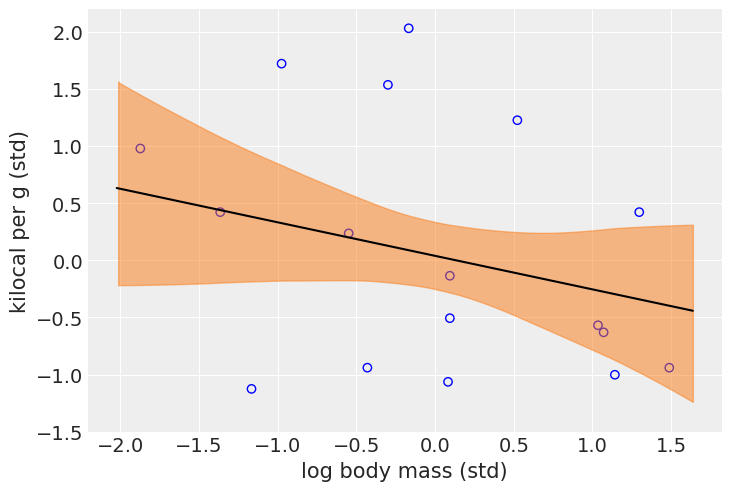

In [ ]:
# xseq_M = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
xseq_M = np.linspace(dcc["log(mass)"].min() - 0.15, dcc["log(mass)"].max() + 0.15, 30)
# shared_N.set_value(xseq)

with m5_6:
    pm.set_data({"shared_M": xseq_M})
    m5_6_posterior_predictive = pm.sample_posterior_predictive(m5_6_trace, var_names=["mu"])

mu_ppd_m5_6 = m5_6_posterior_predictive.posterior_predictive["mu"]
mu_mean_m5_6 = mu_ppd_m5_6.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
# ax.scatter(dcc["M"], dcc["K"], facecolors="none", edgecolors="b")
ax.scatter(dcc["log(mass)"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hdi(xseq_M, mu_ppd_m5_6, ax=ax) # The organge 89% compatibility interval
ax.plot(xseq_M, mu_mean_m5_6, c="black") # The black regression line
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("kilocal per g (std)");

From our `m5_6` model, it seems that log mass is negatively associated with kilocalories and the association between them seems to be stronger than the positive relationship between kilocalories and the percentage of neocortex. However, we can see from the top rows in `Figure 5.9` that the regression still seems to be uncertain due to the wide compatibility interval that can be consistent with both weak and strong relationships.

#### Code 5.39 - Using both predictor values in the Multiple Linear Regression model, `m5_7`.

Let's see what happens when we add both predictor values to a Multiple Linear Regression model:

$ K_i \sim \text{Normal}(\mu_i, \sigma) $ \[the likelihood \]

$ \mu_i = \alpha + \beta_N N_i + \beta_M M_i$ \[the multiple linear regression model \]

$ \alpha \sim \text{Normal}(0, 0.2) $ \[the $\alpha$ prior \]

$ \beta_N \sim \text{Normal}(0, 0.5) $ \[the $\beta_N$ prior \]

$ \beta_M \sim \text{Normal}(0, 0.5) $ \[the $\beta_M$ prior \]

$ \sigma \sim \text{Exponential}(1) $ \[the $\sigma$ prior \]

In [ ]:
# shared_N = shared(dcc["N"].values)
# shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    # shared_M = pm.Data("shared_M", dcc["M"].values)
    shared_M = pm.Data("shared_M", dcc["log(mass)"].values)
    shared_N = pm.Data("shared_N", dcc["N"].values)

    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.extract_dataset(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.048,0.144,-0.226,0.319,0.001,0.001,13873.0,13226.0,1.0
bN,0.573,0.275,0.040,1.073,0.003,0.002,11868.0,11886.0,1.0
bM,-0.682,0.277,-1.183,-0.149,0.003,0.002,11265.0,12347.0,1.0
sigma,0.877,0.183,0.573,1.216,0.002,0.001,11803.0,12482.0,1.0


#### 5.40

By including both predictor variables in this multiple linear regression, the posterior relationship between both predictor variables to the target has increased. We can compare the distributions of our new model with the simple linear regression models we created earlier modelling the relationship between kilocalories and neocortex percentage, `m5_5`, and adult female body mass, `m5_6`, using the forest plot below.

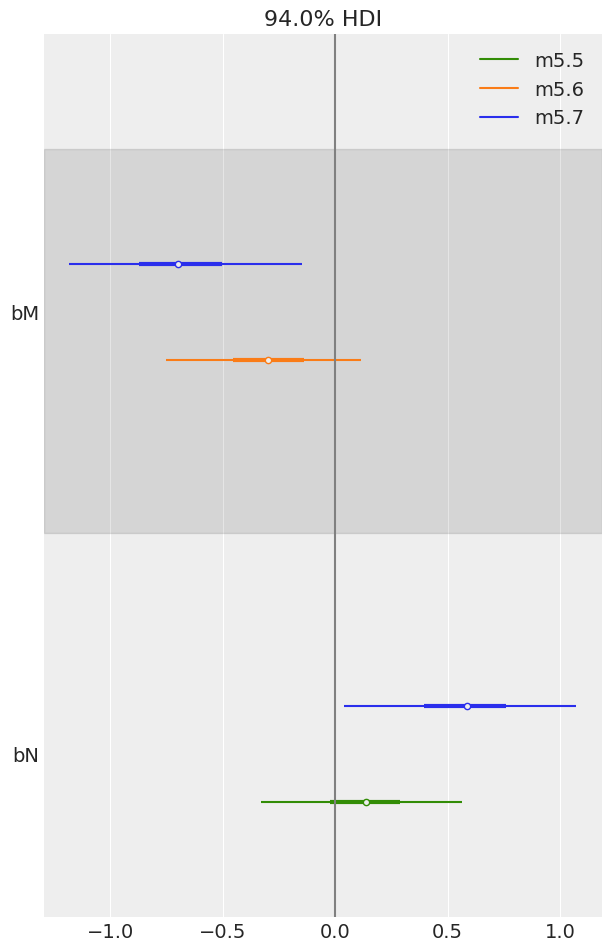

In [ ]:
az.plot_forest(
    [m5_7_trace, m5_6_trace, m5_5_trace],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
)

plt.axvline(x=0, color="grey")

As we can see, the posterior distributions for both body mass (`bM`) and percentage of neocortex (`bN`) have moved away from zero as opposed to the bivariate models we built earlier. Adding both predictors seems to have moved their estimates apart. But how did adding the independent variables for neocortex and body mass both lead to a stronger association with the dependent variable for kilocalories in milk?

In this context, both independent variables were correlated with the dependent variables where the neocortex percentage had a positive correlation while the female body mass had a negative correlation with kilocalories. In addition, both predictor variables were positively correlated with one another.

What's amazing is that our Multiple Linear Regression model automatically found the most revealing cases and used them to produce inference! If we humoured ourselves by anthropomorphizing how our multiple linear regression model thought, it probably asked itself whether a species with a high percentage of neocortex *for their body mass* produces a higher concentration of energy within their milk? In addition, the model must have also asked itself the inverse for whether a species with a high percentage of body mass *relative to their percentage of neocortex* produced high-energy milk? For example, bigger species such as apes have milk but with less energy. On the other hand, species with a higher percentage of neocortex tend to have richer levels of energy in their milk. The fact that our two predictors of body size and neocortex are correlated makes it difficult to spot their relationship unless we account for both variables.

From the relationships we just investigated, we can plausibly build three DAGs to explain the data:

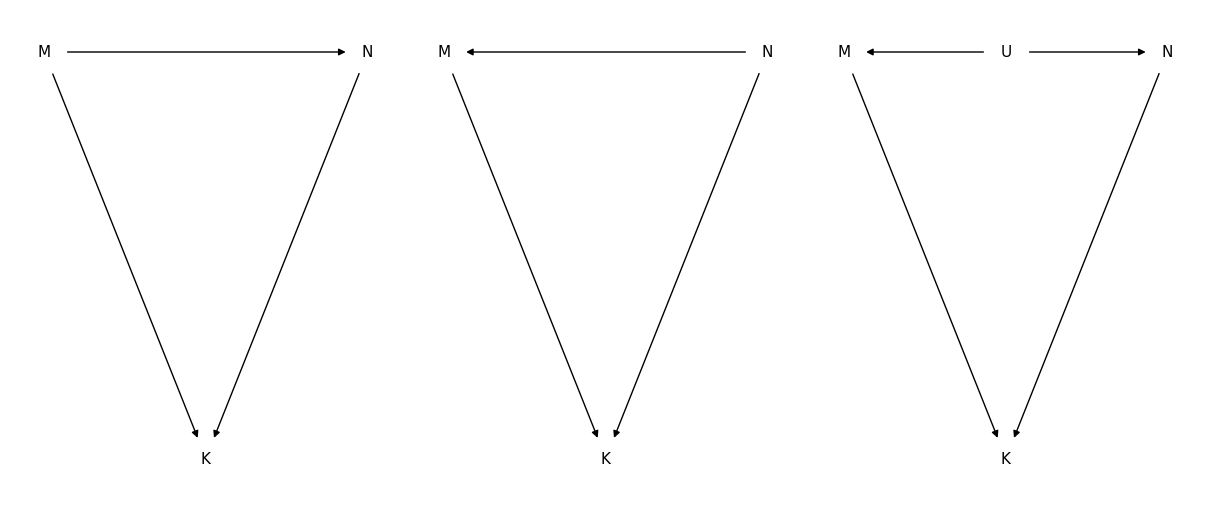

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 5))


#############
### DAG 1 ###
#############
# Creating a directed CYCLIC graph
DAG1_5_2 = nx.DiGraph()

# Add nodes
DAG1_5_2.add_node("M", pos=(0, 0))
DAG1_5_2.add_node("N", pos=(1, 0))
DAG1_5_2.add_node("K", pos=(0.5, -1))

# Add edges (vertices)
DAG1_5_2.add_edge("M", "N")
DAG1_5_2.add_edge("N", "K")
DAG1_5_2.add_edge("M", "K")

# Get node positions
node_positions1_5_2 = nx.get_node_attributes(DAG1_5_2, 'pos')

# Draw the graph
nx.draw(DAG1_5_2, ax=ax[0], pos=node_positions1_5_2, with_labels=True, node_size=1000, font_size=11, font_color='black', node_color='white')


#############
### DAG 2 ###
#############
# Creating a directed ACYCLIC graph
DAG2_5_2 = nx.DiGraph()

# Add nodes
DAG2_5_2.add_node("M", pos=(0, 0))
DAG2_5_2.add_node("N", pos=(1, 0))
DAG2_5_2.add_node("K", pos=(0.5, -1))

# Add edges (vertices)
DAG2_5_2.add_edge("N", "M")
DAG2_5_2.add_edge("N", "K")
DAG2_5_2.add_edge("M", "K")

# Get node positions
node_positions2_5_2 = nx.get_node_attributes(DAG2_5_2, 'pos')

# Draw the graph
nx.draw(DAG2_5_2, ax=ax[1], pos=node_positions2_5_2, with_labels=True, node_size=1000, font_size=11, font_color='black', node_color='white')


#############
### DAG 3 ###
#############
# Creating a directed ACYCLIC graph
DAG3_5_2 = nx.DiGraph()

# Add nodes
DAG3_5_2.add_node("U", pos=(0.5, 0))
DAG3_5_2.add_node("M", pos=(0, 0))
DAG3_5_2.add_node("N", pos=(1, 0))
DAG3_5_2.add_node("K", pos=(0.5, -1))

# Add edges (vertices)
DAG3_5_2.add_edge("U", "M")
DAG3_5_2.add_edge("U", "N")
DAG3_5_2.add_edge("N", "K")
DAG3_5_2.add_edge("M", "K")

# Get node positions
node_positions3_5_2 = nx.get_node_attributes(DAG3_5_2, 'pos')

# Draw the graph
nx.draw(DAG3_5_2, ax=ax[2], pos=node_positions3_5_2, with_labels=True, node_size=1000, font_size=11, font_color='black', node_color='white')

With the left-most DAG, we can infer a similar relationship we saw with age, marriage rates, and divorce where mass can influence the percentage of neocortex in the brain and then both variables subsequently affect the kilocalories in milk. In the middle DAG, we see the opposite where the percentage of neocortex influences mass which causes it to both directly, and indirectly through mass, influence the amount of energy in milk.

What's interesting is the graph on the right which we haven't encountered quite yet. The $U$ in the graph represents a *unobserved variable*, or a *confounding variable*, that influences both $M$ and $N$ and explains the causation between them.

From just the graph, we can't tell which graph is right because they imply the same set of **conditional dependencies** where each pair of variables is associated, regardless of what we condition them on. On the other hand, if we find ourselves in a situation where a set of DAGs has the same conditional independencies, this is known as a **Markov equivalence** set.

#### 5.41
This code actually produces right plot Confirmed from Professor McElreath that the book text is mistaken.

In [ ]:
# xseq_M = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
# shared_N.set_value(np.zeros(30))
# shared_M.set_value(xseq)


with m5_7:
    pm.set_data({"shared_M": xseq_M})
    pm.set_data({"shared_N": np.zeros(30)})
    m5_7_posterior_predictive_n0 = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"])

mu_ppd_m5_7_n0 = m5_7_posterior_predictive_n0.posterior_predictive["mu"]
mu_mean_m5_7_n0 = mu_ppd_m5_7_n0.mean(dim=["chain", "draw"])

Output()

In [ ]:
with m5_7:
    pm.set_data({"shared_M": np.zeros(30)})
    pm.set_data({"shared_N": xseq})
    m5_7_posterior_predictive_m0 = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"])

mu_ppd_m5_7_m0 = m5_7_posterior_predictive_m0.posterior_predictive["mu"]
mu_mean_m5_7_m0 = mu_ppd_m5_7_m0.mean(dim=["chain", "draw"])

Output()

#### Figure 5.9. Milk energy and neocortex among primates.

The last thing we should do with these models is to make counterfactual plots in the bottom row of `Figure 5.9` where we suppose that the DAG on the far right with the unobservable variable is correct, but instead, both $M$ and $N$ are free from the influence of $U$ and both directly influence $K$.

The bottom left-hand plot visualizes the direct, positive effect of $N$eocortex percentage influencing $K$ilocalories of milk. While on the bottom right, we can observe the negative relationship between $M$ass and $K$ilocalories. Again, both these display the relationship that they would have on the target variable independently without the effect of either their counterpart of the theoretical unobserved/confounding variable in the DAG.

<ipython-input-135-3f08b5f0486b>:61: UserWarning:

The figure layout has changed to tight



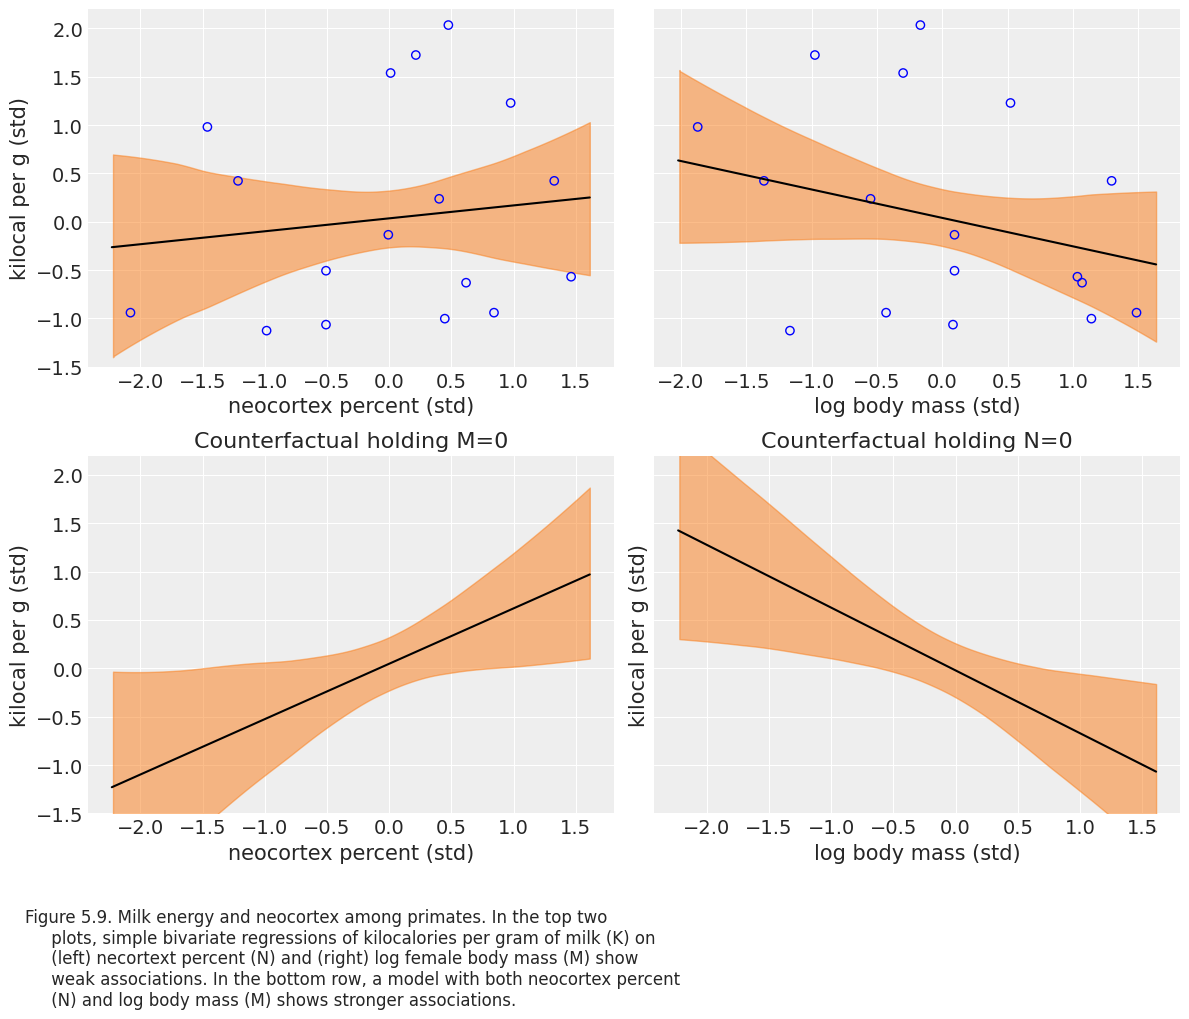

In [ ]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(12, 10))

#########################################
### Plot 1 - Neocortext Percent (std) ###
#########################################
az.plot_hdi(xseq, mu_ppd_m5_5, ax=ax[0, 0])
ax[0, 0].plot(xseq, mu_mean_m5_5, c="black")
ax[0, 0].scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax[0, 0].set_ylim(-1.5, 2.2)
ax[0, 0].set_xlabel("neocortex percent (std)")
ax[0, 0].set_ylabel("kilocal per g (std)")


####################################
### Plot 2 - Log Body Mass (std) ###
####################################
az.plot_hdi(xseq_M, mu_ppd_m5_6, ax=ax[0, 1])
ax[0, 1].plot(xseq_M, mu_mean_m5_6, c="black")
# ax[0, 1].scatter(dcc["M"], dcc["K"], facecolors="none", edgecolors="b")
ax[0, 1].scatter(dcc["log(mass)"], dcc["K"], facecolors="none", edgecolors="b")
ax[0, 1].set_ylim(-1.5, 2.2)
ax[0, 1].set_xlabel("log body mass (std)")


#############################################
### Plot 3 - Counterfactual holding M = 0 ###
#############################################
az.plot_hdi(xseq, mu_ppd_m5_7_m0, ax=ax[1, 0])
ax[1, 0].plot(xseq, mu_mean_m5_7_m0, c="black")

ax[1, 0].set_ylim(-1.5, 2.2)
ax[1, 0].set_title("Counterfactual holding M=0")
ax[1, 0].set_ylabel("kilocal per g (std)")
ax[1, 0].set_xlabel("neocortex percent (std)")


#############################################
### Plot 4 - Counterfactual holding N = 0 ###
#############################################
az.plot_hdi(xseq, mu_ppd_m5_7_n0, ax=ax[1, 1])
ax[1, 1].plot(xseq, mu_mean_m5_7_n0, c="black")

ax[1, 1].set_ylim(-1.5, 2.2)
ax[1, 1].set_title("Counterfactual holding N=0")
ax[1, 1].set_ylabel("kilocal per g (std)")
ax[1, 1].set_xlabel("log body mass (std)")


# Adding the graph explanations from the textbook
plt.suptitle(
    x=0.3,
    y=-0.03,
    t="Figure 5.9. Milk energy and neocortex among primates. In the top two \n \
    plots, simple bivariate regressions of kilocalories per gram of milk (K) on \n \
    (left) necortext percent (N) and (right) log female body mass (M) show \n \
    weak associations. In the bottom row, a model with both neocortex percent \n \
    (N) and log body mass (M) shows stronger associations.",
    ma="left"
  )

fig.tight_layout()
plt.show()

#### Overthinking: Simulating a masking relationship.

\*\**If you want, you can ignore this section as it's not particularly useful with the code provided*

As we've done with our divorce rate example in *Section 5.1.,* it's helpful to simulate data in which two meaningful predictors mask one another to understand spurious association which we'll code and visualize below:

#### 5.42

In [ ]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})

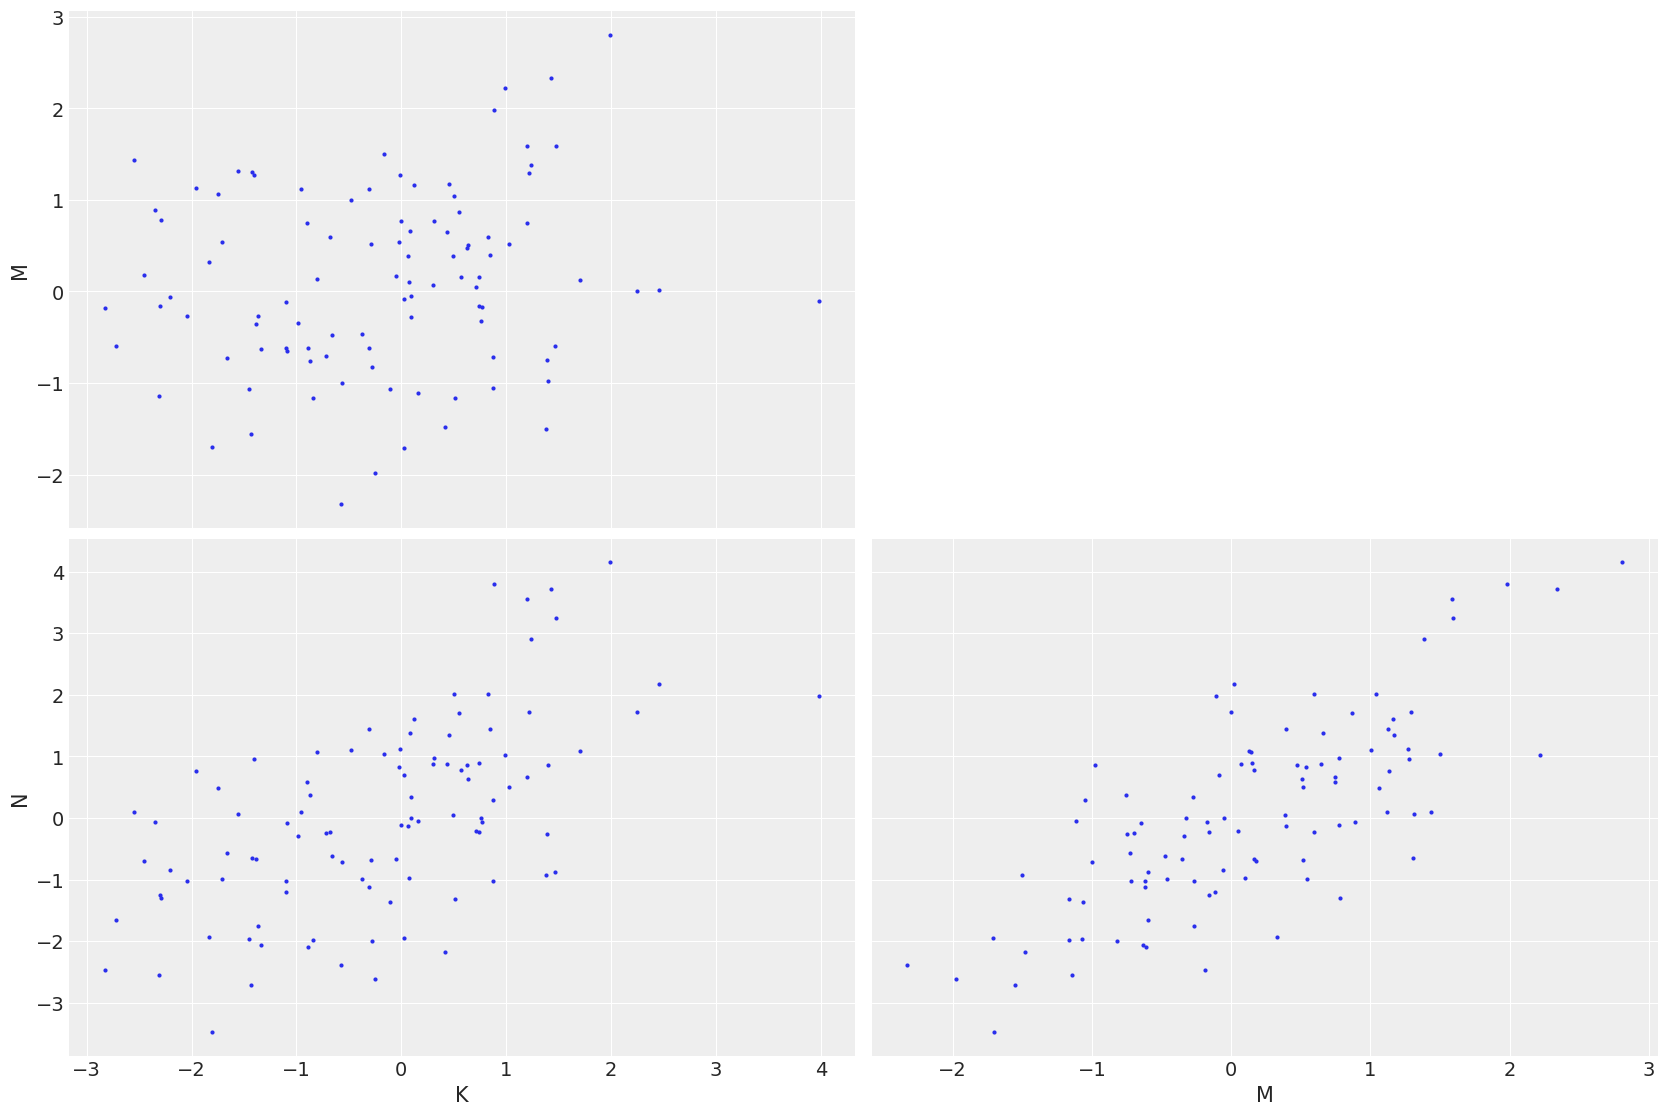

In [ ]:
# Professor McElreath suggests viewing the pair plots
az.plot_pair({"M": M, "N": N, "K": K});

#### 5.43

If you want, we see the masking pattern of inferences by replacing the data in the `dcc` DataFrame with the ones we've simulated in `d_sim` in our `m_5_5`, `m_5_6`, and `m_5_7` models:

In [ ]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

#### 5.44

In the primate milk example, the positive relationship between body mass and the proportion of the neocortex may represent a tradeoff between lifespan and learning. Large animals tend to live a long time but the investment in learning can prove to be more fruitful since the benefits of it can be amortized over a longer lifespan. If we follow this logic, then both large body mass and a large proportion of the neocortex can influence the kilocalories in milk composition but in different directions and for different reasons. Therefore, the leftmost DAG just above `Code 5.40` is the correct one. However, we cannot easily see which is truly correct based on the evidence we have on hand?

To compute the **Markov Equivalence**, let's build a DAG using the `networkx` library to visualize this causal relationship:

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



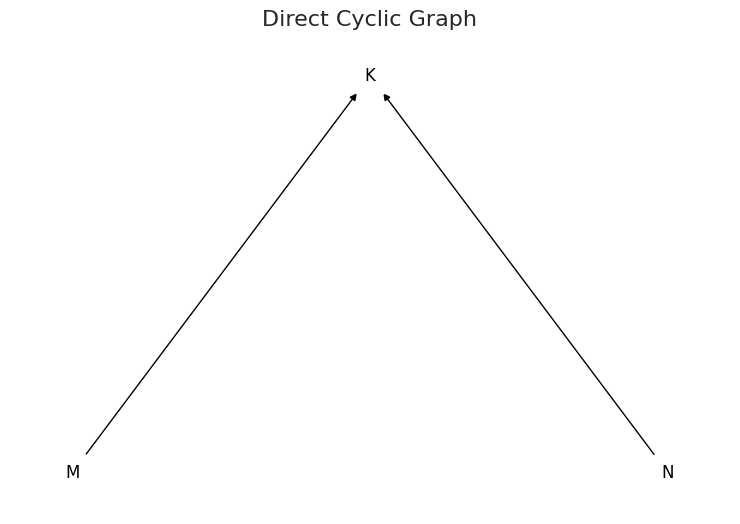

In [ ]:
# Create a directed graph
Di = nx.DiGraph()

# Add nodes
Di.add_node("M", pos=(0, 0.5))
Di.add_node("N", pos=(2, 0.5))
Di.add_node("K", pos=(1, 1))

# Add edges (vertices)
Di.add_edge('M', 'K')
Di.add_edge('N', 'K')

# Get node positions
node_positions0 = nx.get_node_attributes(Di, 'pos')

# Draw the graph
nx.draw(Di, node_positions0, with_labels=True, node_size=1000, font_size=12, font_color='black', node_color='white')

# Display the graph
plt.title("Direct Cyclic Graph")
plt.show()

## *Section 5.3* - Categorical Variables

A common question that's asked in the literature is to what extent an outcome can change by the presence (or absence) of a **categorical variable**, which are variables where the values in them are discrete and unordered. For example with the milk data, the `species` column had animals like apes or [New World monkeys](https://en.wikipedia.org/wiki/New_World_monkey). Another name for these types of variables is called **factors** and can be included in linear models but it's not widely understood how they are represented. Knowing how a model interprets these types of variables in the posterior distribution gives us additional superpowers when engineering our golems.

### Rethinking: Continuous countries.

Automated software and lack of attention can lead to damaging consequences for golem engineers who use categorical variables to build their machinery. One famous cautionary tale was in 2015 when there was a paper that published results in a top journal which found that there apparently was a negative association between religiosity and generosity from a study on 1,170 children in six countries. This immediately caused controversy in the community as it disagreed with existing literature and knowledge on this subject. Upon further analysis, researchers found that the issue with the paper's findings was that they had assigned the `countries` variable in the model to be a continuous variable which highly skewed its results.

### 5.3.1 Binary categories.

The moral of the story is that categorical variables must be used with caution and must be well understood if we are to include them in linear models. To explore how to best handle them, let's bring back the dataset on the !Kung San population which used the `sex` of a person to predict their height:

#### 5.45

In [ ]:
# d = pd.read_csv(os.path.join("Data", "Howell1.csv"), delimiter=";")
path = "https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/Howell1.csv"
d = pd.read_csv(path, delimiter=";")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### 5.46

Again with this dataset, the `male` field is our predictor variable and represents an instance as an indicator variable, also sometimes known as a **dummy variable**. **Indicator variables** are techniques meant for encoding unordered categorical variables in quantitative models where the $1$ is simply meant to indicate the presence of that variable, which in this case is male. This column could have just as easily been renamed as `female` to indicate which rows contain a female subject but the important thing to remember is that we name the variable after the category assigned to the $1$ value.

To use the dummy variable as a predictor in our model, we can include it with the linear model as if it was a typical predictor value where it would have the effect of "turning on" the parameter during the presence of the `male` subject, otherwise "turning off" the parameter when processing a row with a `female` subject.

Let's bring back the Linear Model for height we used in Chapter 4 to make sense of using a categorical variable:

$ h_i \sim \text{Normal}(\mu_i, \sigma) $

$ \mu_i = \alpha + \beta_m m_i $

$ \alpha \sim \text{Normal}(178, 20) $

$ \beta_m \sim \text{Normal}(0, 10) $

$ \sigma \sim \text{Uniform}(0, 50) $


$ \text{Where:} $

- $h_i$ is an individual's height in cm;

- $m_i$ is our dummy variable representing a person's sex

- $\beta_m $ is the slope or weight of the parameter IF the dummy variable is `male` ($\mu_i = \alpha + \beta_m(1)$). And if the dummy variable is `female`, then the average height simply equals the y-intercept of the linear model ( $\mu_i = \alpha $).

So in essence, the $\beta_m$ parameter for our simple linear model using dummy variables simply represents the *difference* between male and female heights and the $\alpha$ parameter now represents the average female height rather than the average height. Under this model, our priors don't make much sense anymore. Another issue with this model is that it assumes there is more uncertainty about the subject of our dummy variable which is `male`. However, we know this isn't true because we could have just as easily changed the dummy variable to represent females and the model would then just assign more uncertainty to females than to males unnecessarily.

To check our assumption, let's simulate what the values would be for our prior distributions:

In [ ]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_female,178.206,19.873,139.663,213.152
mu_male,177.338,23.335,135.175,222.407


As we can see, the distribution, $\mu$, for our male parameter is wider because it uses both parameters ($\alpha$ and $\beta$) as opposed to the female which just uses the $\alpha$ parameter but this shouldn't be the case.

#### 5.47

Another option that's available to us is to use an **index variable** which contains the integers that correspond to different categories. So in this instance, "1" means female and "2" means male but no order is implied.

In [ ]:
sex = d["male"].values
d['sex'] = d['male'].apply(lambda x: 2 if x == 1 else 1)

print(type(sex))
d['sex'].head()

<class 'numpy.ndarray'>


,sex
0,2
1,1
2,1
3,2
4,1


#### 5.48

The reason why it's better to process the categorical variable this way instead of using dummy variables is so we're not necessarily "turning off" the slope parameter, $\beta_i$, every time we encounter a female subject. Therefore, the mathematical version of this model becomes:

$ h_i \sim \text{Normal}(\mu_i, \sigma) $

$ \mu_i = \alpha_\text{sex}[i] $

$ \alpha_j \sim \text{Normal}(178, 20) $ for $j = 1..2$

$ \sigma \sim \text{Uniform}(0, 50) $

In [ ]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.903,1.536,132.005,137.658,0.031,0.022,2516.0,1408.0,1.0
mu[1],142.626,1.730,139.478,145.796,0.033,0.023,2816.0,1574.0,1.0
sigma,27.427,0.833,25.867,28.991,0.017,0.012,2216.0,1355.0,1.0


#### 5.49

The advantage to applying a Bayesian framework to Linear Models is that it's easy enough to interpret the parameters in our model - they are just the expected heights in our `male`/`female` indicator variable. This is great, but what we're often really after is the expected differences between the sexes which we can actually extract by calculating the differences in the sampled posterior distribution. Note that by adding the `shape=2` argument when defining the `mu` prior, we're telling the model to generate two `Normal()` distributions of equal shape based on the observed height values as opposed to just one so that we can calculate the expected **contrast** between males and females in the sample:

In [ ]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)

    # With PyMC it's easier just to create a deterministic that includes both values
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])

    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff,-7.685,2.298,-12.342,-3.720,0.044,0.032,2688.0,1754.0,1.0
mu[0],134.907,1.622,131.764,137.786,0.031,0.022,2734.0,1268.0,1.0
mu[1],142.592,1.719,139.323,145.797,0.031,0.022,3069.0,1676.0,1.0
sigma,27.425,0.827,25.840,28.902,0.016,0.012,2594.0,1342.0,1.0


### 5.3.2. Many categories.

Binary dummy variables are relatively easy when including them in a model but the complexity starts to grow exponentially as you add more categories within a single variable. With every unique category, $k$, in our variable, we'll need to add one more until there are $k-1$ indicator variables in our model. For example, with each unique Hogwarts School of Witchcraft and Wizardry `house` ($k=4$) from the Harry Potter franchise pictured below, we will need to add a total of 3 indicator variables in our model.

For many analysts, dummy variables of $0$ and $1$ are the default choice but we believe that index variables of $1$ and $2$ are safer choices for the reasons we discussed earlier of inadvertently "turning off" certain parameters in our model. Adding more indicator variables to our models essentially functions the same as if it were only a binary variable.

<img src="https://static1.srcdn.com/wordpress/wp-content/uploads/2020/08/Hogwarts-House-Crests-.jpg?q=70&fit=crop&w=1140&h=&dpr=1" width=750 height=400>

[Source](https://screenrant.com/harry-potter-best-worst-traits-hogwarts-house/)

#### 5.50

Now let's revisit the primate milk dataset again but this time, let's include the `clade` variable in our model which encompasses the broad taxonomic membership between each specie of primate:

In [ ]:
# d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
github = "https://raw.githubusercontent.com/vanislekahuna/Statistical-Rethinking-PyMC/refs/heads/main/Data/milk.csv"
d = pd.read_csv(github, delimiter=";")
d["clade"].value_counts()

,count
clade,
New World Monkey,9
Ape,9
Old World Monkey,6
Strepsirrhine,5


In [ ]:
d["clade"].unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

#### 5.51

With our dataset now handy, let's assign a **index variable** to each category in our `cade` column:

In [ ]:
d["clade_id"] = pd.Categorical(d["clade"]).codes
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,3
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,3
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,3
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,3
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,3


#### 5.52

With our new predictor variable, let's build a mathematical model for forecasting the average kilocalories produced by the milk ($K$) using `clade` as the single predictor:

$ K_i \sim \text{Normal}(\mu_i, \sigma)$

$ \mu_i = \alpha_\text{clade}[i] $

$ \alpha_j \sim \text{Normal}(0, 0.5) $ for $j = 1..4$

$ \sigma \sim \text{Exponential}(1) $

In [ ]:
# k + 1 so we can include all the mu distributions in our model
k_dists = d["clade_id"].max() + 1

Output()

Output()

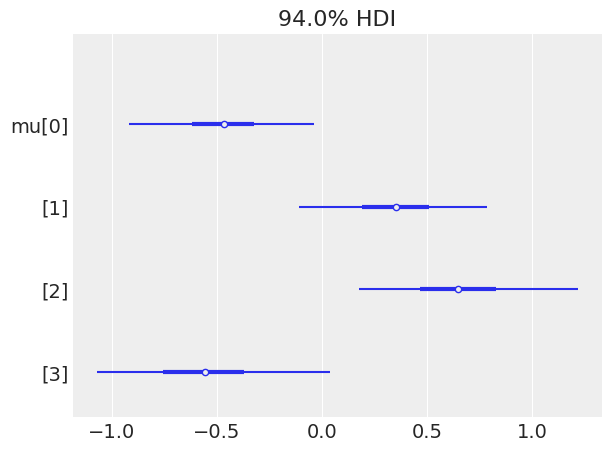

In [ ]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=[k_dists])
    K = pm.Normal("K", mu[d["clade_id"].values], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);

Text(0.5, 1.0, '')

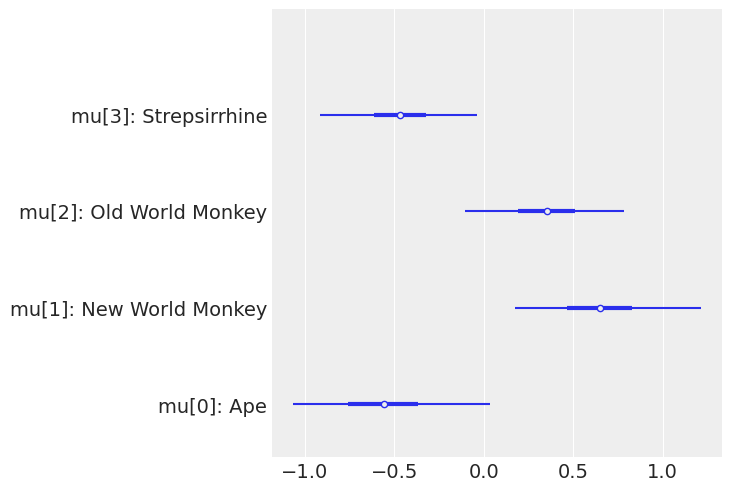

In [ ]:
# Create a mapping from numeric indices to clade names
clade_mapping = {
    0: "Ape",
    1: "New World Monkey",
    2: "Old World Monkey",
    3: "Strepsirrhine"
}

# Extract the posterior samples for mu
mu_samples = m5_9_trace.posterior["mu"]

# Create a list of labels for the y-axis
y_labels = [f"mu[{i}]: {clade_mapping[i]}" for i in range(k_dists)]

# Plot the forest plot with custom labels
fig, ax = plt.subplots()

az.plot_forest(
    mu_samples,
    combined=True,
    var_names=["mu"],
    hdi_prob=0.94,
    ax=ax
)

# Set custom y-axis labels
ax.set_yticklabels(y_labels)
ax.set_title("")

#### 5.53

With the `plot_forest()` object above, I added some additional code to help us map each `mu` distribution with its corresponding monkey specimen. We can demonstrate the same thing by associating each row with a made-up category. In our toy example below, we'll assign each monkey subject to a Hogwarts `house`:

In [ ]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id,K,house
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,3,-0.940041,2
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,3,-0.816126,3
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,3,-1.125913,0
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,3,-1.001998,1
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,3,-0.258511,3


#### 5.54

With that, we can now include the Hogwarts houses as another categorical predictor variable in our model:

In [ ]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=[d["house"].max() + 1])
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=[d["clade_id"].max() + 1])
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_10_trace = pm.sample()

az.summary(m5_10_trace, var_names=["mu_clade", "mu_house"])

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.383,0.272,-0.905,0.110,0.006,0.005,1818.0,1626.0,1.0
mu_clade[1],0.331,0.267,-0.144,0.851,0.006,0.004,1917.0,1625.0,1.0
mu_clade[2],0.784,0.300,0.208,1.332,0.007,0.005,1660.0,1613.0,1.0
mu_clade[3],-0.665,0.311,-1.247,-0.097,0.007,0.005,1772.0,1618.0,1.0
mu_house[0],-0.460,0.275,-1.004,0.061,0.006,0.005,1795.0,1614.0,1.0
mu_house[1],0.076,0.286,-0.442,0.618,0.006,0.005,2016.0,1849.0,1.0
mu_house[2],0.002,0.256,-0.492,0.460,0.006,0.005,1715.0,1574.0,1.0
mu_house[3],0.420,0.327,-0.163,1.026,0.008,0.006,1879.0,1567.0,1.0


Text(0.5, 1.0, 'Monkeys sorted in Hogwarts Houses')

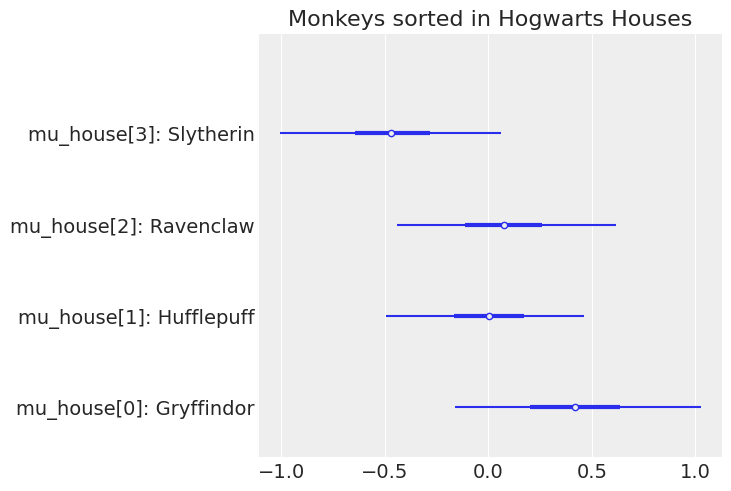

In [ ]:
# Create a mapping from numeric indices to house names
hogwarts_houses = {
    0: "Gryffindor",
    1: "Hufflepuff",
    2: "Ravenclaw",
    3: "Slytherin"
}

# Extract the posterior samples for the variable
variable = "mu_house"
mu_10_samples = m5_10_trace.posterior[variable]

# Create a list of labels for the y-axis
y_labels = [f"{variable}[{i}]: {hogwarts_houses[i]}" for i in range(k_dists)]

# Plot the forest plot with custom labels
fig_hp, ax_hp = plt.subplots()

az.plot_forest(
    mu_10_samples,
    combined=True,
    var_names=[variable],
    hdi_prob=0.94,
    ax=ax_hp
)

# Set custom y-axis labels
ax_hp.set_yticklabels(y_labels)
ax_hp.set_title("Monkeys sorted in Hogwarts Houses")

### Rethinking: Differences and statistical significance.

## *Section 5.4* - Summary

- In the case of linear regression, there's no way to know which independent predictor variable \(median age and marriage rate\) is best at predicting the dependent target variable \(divorce rate\) by doing separate linear regressions.
- Instead, we need to make causal assumptions about our data. For example, does age directly affect divorce ($ A → D$)? Or perhaps age indirectly affects it by influencing the marriage rate ($ A → M → D$)?  Alternatively, is it possible that the marriage rate may also be influencing the divorce rate through age ($M → A → D $)?
- **Multiple Linear Regression** helps us solve this question by helping us understand whether there's additional value in knowing another variable from the predictor variables that we already know. For example, if we condition on one variable, in this case, $A$, we can see whether it accurately predicts our target variable, $D$, independently of $M$. After fitting our Multiple Regression model to predict divorce rates, we're therefore better suited to answer the following questions:

> 1. After I already know the marriage rate of a given state, what additional value is there in also knowing the median age of marriage?
>
> 2. After I already know the median age of marriage for a given state, what additional value is there in also knowing the marriage rate?

- From the forest plot in Code `5.11`, we can clearly see that when comparing the marriage rate parameter on our Multiple Linear Regression model `m5_3` against the Simple Linear Regression model `m5_2`, the $\beta_M$ parameter significantly fell much closer to $0$ when the median age $\beta_A$ parameter was included in the model. This implies that there isn't much value in using the marriage rate $M$ to predict divorce rates $D$ if we have information on the median age of marriage $A$ parameter.
- Therefore the DAG on the right that we built in Section 5.1.2 is likely the more accurate one between the two.
- One of the downsides of utilizing Multi-Linear Regression models is that it's slightly more challenging to interpret how the IVs impact the DV. Luckily for us, we have three tools at our disposal that may help us better understand these relationships in our model:

> 1. Predictor residual plots / **Residual sum of squares ($R^2$)**: While the slope value of each independent variable helps us understand how they individually swing the model's prediction of the dependent variable, so too can each predictor's **residual sum of squares \($R^2$\)** help us capture this information by calculating the amount of variance that each predictor accounts for in its prediction. As a reminder, a perfect $R^2$ score of $1$ indicates that the model perfectly captured all the variance in the model but this may also be a sign of the model overfitting. In addition to calculating the $R^2$ for each predictor, it's also useful to plot each data point's residual against the target variable like we did in the bottom row of `Figure 5.4` to visually inspect each predictor's preformance against the target. For additional reference, here is the formula to calculate the residual sum of squares: $ R^2 = \frac{SS_{resid}}{SS_{total}} = \frac{\sum_{i=1}^n (y_i - \hat{y})^2}{\sum_{i=1}^n (y_i - \bar{y})^2} $
>
> 2. Another technique we can utilize is to generate a **posterior predictive plot** like we did in `Figure 5.5` which plots our predicted values against the actual values to see how close they are to a regression line which represents the instances where our prediction exactly matches the actual value.
>
> 3. The last technique we can deploy is to build a **counterfactual plot** which is almost like a stress test of a model by using simulated data to inform a specific parameter and then observing how the model reacts. For example, if we use completely new, simulated data to inform the marriage rate prior and model its relationship with the divorce rate ($M → D$) like we did in `Figure 5.7`, we would still end up with a relatively flat relationship indicating that marriage rate doesn't do as much to help us predict the divorce rate for a given state.

- If we want to include categorical variables in our analysis, the best thing to do is to apply an **index variable** to each class within the categorical variable. For example, if we have `sex` as a predictor variable, we can assign the following indexes to each class: $male = 1$ & $female = 2$. The same rules would apply even if we had multiple classes within our categorical variable. By assigning an index variable, we could even differentiate how the prior and posterior distributions change for each class. However, the mathematical notation for the linear model would change slightly to a format similar to the following:


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ h_i \sim \text{Normal}(\mu_i, \sigma) $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ \mu_i = \alpha_\text{sex}[i] $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ \alpha_j \sim \text{Normal}(178, 20) $ for $j = 1..2$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ \sigma \sim \text{Uniform}(0, 50) $

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w